# Improving Customer Satisfaction using Current Feedback

In this project we will be assessing current customer satisfaction feedback related to an anonymised real airline, known in this dataset as Invistico.

We want to use the current feedback to determine which of the airline's many features:
1. Most impact customer satisfaction.
2. Can predict future customer experience satisfaction.

Features include things like seat comfort, delayed flights, food and drink and entertainment.

Having a clear idea of the features customers rate most highly as important for their satisfaction is crucial for optimising expenditure, retaining customers loyal and new, and driving growth.

Answering the above questions means we can improve customer satisfaction over time, by ensuring the most satisfying features for customers are rolled out across the airline's fleet or, in the case of negative impact, that these features are improved upon.

The data we are using is from Kaggle, uploaded to that website in 2020. It and can be found [here](https://www.kaggle.com/datasets/sjleshrac/airlines-customer-satisfaction?resource=download). It is real data from a real airline.

### Methodology

The steps we will follow in this project are:

- Cleaning the dataset
- Exploratory analysis and visualisations
- Feature prediction using machine learning (logisitic regression and random forest).


## Cleaning and exploration

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [2]:
#Our dataset
csv = 'Invistico_Airline.csv'

In [3]:
data = pd.read_csv(csv)
df = pd.DataFrame(data)

In [4]:
df.head(3)

satisfaction  Gender   Customer Type  Age   Type of Travel     Class  \
0    satisfied  Female  Loyal Customer   65  Personal Travel       Eco   
1    satisfied    Male  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Female  Loyal Customer   15  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   

   Food and drink  ...  Online support  Ease of Online booking  \
0               0  ...               2                       3   
1               0  ...               2                       3   
2               0  ...               2                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  

[3 rows x 23 columns]

#### Columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

We have a selection of columns related to the services offered on an airline. We'll go through them below:

<br>**satisfaction**: either satisfied or dissatisfied, overall experience reported
<br>**gender**: customer's gender
<br>**customer type**: either 'loyal customer' or 'disloyal customer', i.e. are they a repeat customer or part of a loyalty scheme (not clear from dataset but either acceptable)
<br>**age**: age of customer
<br>**type of travel**: either 'personal' or 'business' travel
<br>**class**: 'Eco' (economy), 'Business', or 'Eco Plus'
<br>**flight distance**: distance of journey
<br><br>The following columns contain the customer's ratings across a variety of features. They are integers, ranking from 0-5
<br>**seat comfort**
<br>**departure/arrival time convenient**
<br>**food and drink**
<br>**gate location**
<br>**inflight wifi service**
<br>**inflight entertainment**
<br>**online support**
<br>**ease of booking online**
<br>**on-board service**
<br>**leg room service**
<br>**baggage handling**
<br>**checkin service**
<br>**cleanliness**
<br>**online boarding**
<br><br>The final two columns give the delay, if any, in minutes for either departure or arrival.
<br>**departure delay in minutes**
<br>**arrival delay in minutes**

Below we will:
- change the column names to be more uniform and easier to work with
- ensure the columns are the correct type
- check for any nulls, outliers or other relevant figures in the data

In [6]:
#Fixing up column headings
new_cols = []

for item in df.columns:
    item = item.lower()
    item = item.replace(' ','_')
    item = item.replace('/','_')
    new_cols.append(item)
    
df.columns=new_cols
df.columns

Index(['satisfaction', 'gender', 'customer_type', 'age', 'type_of_travel',
       'class', 'flight_distance', 'seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes', 'arrival_delay_in_minutes'],
      dtype='object')

In [7]:
#The last column, arrival_delay_in_minutes is a float while it's counterpart for departure is an int. Which is better?
#Do any of the float-type rows use the decimal?

dec_filter = df['arrival_delay_in_minutes'] %1==0 
df[~dec_filter]['arrival_delay_in_minutes'].unique() #filtering any with non-0 as the decimal point

array([nan])

So the arrival_delay_in_minutes column has some NaN values, but otherwise is all around numbers.

We'll change these NaN values to 0 and convert to float. I'm also going to add a column that denotes if there was a delay of over 15 minutes. I've picked this number based on the mean for that column, shown below. Given that the 75th percentile is 12 minutes delayed, it seems that 15 minutes is a good choice to indicate if a flight has had a delay or not (any shorter and we'd be including fairly minor stuff).

In [8]:
df['departure_delay_in_minutes'].describe()

count    129880.000000
mean         14.713713
std          38.071126
min           0.000000
25%           0.000000
50%           0.000000
75%          12.000000
max        1592.000000
Name: departure_delay_in_minutes, dtype: float64

In [9]:
df['arrival_delay_in_minutes'] = df['arrival_delay_in_minutes'].fillna(0).astype(int)

In [10]:
delays = df['departure_delay_in_minutes'] > 15
df['was_delayed'] = delays == True

In [11]:
df

satisfaction  gender      customer_type  age   type_of_travel  \
0          satisfied  Female     Loyal Customer   65  Personal Travel   
1          satisfied    Male     Loyal Customer   47  Personal Travel   
2          satisfied  Female     Loyal Customer   15  Personal Travel   
3          satisfied  Female     Loyal Customer   60  Personal Travel   
4          satisfied  Female     Loyal Customer   70  Personal Travel   
...              ...     ...                ...  ...              ...   
129875     satisfied  Female  disloyal Customer   29  Personal Travel   
129876  dissatisfied    Male  disloyal Customer   63  Personal Travel   
129877  dissatisfied    Male  disloyal Customer   69  Personal Travel   
129878  dissatisfied    Male  disloyal Customer   66  Personal Travel   
129879  dissatisfied  Female  disloyal Customer   38  Personal Travel   

           class  flight_distance  seat_comfort  \
0            Eco              265             0   
1       Business             2464             0   
2            Eco             2138             0   
3            Eco              623             0   
4            Eco              354             0   
...          ...              ...           ...   
129875       Eco             1731             5   
129876  Business             2087             2   
129877       Eco             2320             3   
129878       Eco             2450             3   
129879       Eco             4307             3   

        departure_arrival_time_convenient  food_and_drink  ...  \
0                                       0               0  ...   
1                                       0               0  ...   
2                                       0               0  ...   
3                                       0               0  ...   
4                                       0               0  ...   
...                                   ...             ...  ...   
129875                                  5               5  ...   
129876                                  3               2  ...   
129877                                  0               3  ...   
129878                                  2               3  ...   
129879                                  4               3  ...   

        ease_of_online_booking  on-board_service  leg_room_service  \
0                            3                 3                 0   
1                            3                 4                 4   
2                            2                 3                 3   
3                            1                 1                 0   
4                            2                 2                 0   
...                        ...               ...               ...   
129875                       2                 3                 3   
129876                       3                 2                 3   
129877                       4                 4                 3   
129878                       3                 3                 2   
129879                       4                 5                 5   

        baggage_handling  checkin_service  cleanliness  online_boarding  \
0                      3                5            3                2   
1                      4                2            3                2   
2                      4                4            4                2   
3                      1                4            1                3   
4                      2                4            2                5   
...                  ...              ...          ...              ...   
129875                 4                4            4                2   
129876                 3                1            2                1   
129877                 4                2            3                2   
129878                 3                2            1                2   
129879                 5                3            3     

We can see from when we called df.info() earlier that arrival_delay_in_minutes is the only column with nulls, so happy to move on. 

We'll now check for outliers/wrong data.

In [12]:
#Some organising for filter use

rating_cols = ['seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding']

numeric_cols = ['flight_distance', 'seat_comfort',
       'departure_arrival_time_convenient', 'food_and_drink', 'gate_location',
       'inflight_wifi_service', 'inflight_entertainment', 'online_support',
       'ease_of_online_booking', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'cleanliness', 'online_boarding',
       'departure_delay_in_minutes', 'arrival_delay_in_minutes']

cat_cols = ['satisfaction', 'gender', 'customer_type', 'age', 'type_of_travel',
       'class']

In [13]:
#First to confirm nulls and the unique vals of each column

def data_checker(dataframe):
    checklist = []
    columns = dataframe.columns
    for item in columns:
        nulls = dataframe[item].isnull().sum()
        uniques = dataframe[item].nunique()
        checklist.append([item,nulls,uniques])
    checker_df = pd.DataFrame(checklist)
    checker_df.columns = ['column', 'total_nulls', 'total_unique_values']
    return checker_df

data_checker(df)

column  total_nulls  total_unique_values
0                        satisfaction            0                    2
1                              gender            0                    2
2                       customer_type            0                    2
3                                 age            0                   75
4                      type_of_travel            0                    2
5                               class            0                    3
6                     flight_distance            0                 5398
7                        seat_comfort            0                    6
8   departure_arrival_time_convenient            0                    6
9                      food_and_drink            0                    6
10                      gate_location            0                    6
11              inflight_wifi_service            0                    6
12             inflight_entertainment            0                    6
13                     online_support            0                    6
14             ease_of_online_booking            0                    6
15                   on-board_service            0                    6
16                   leg_room_service            0                    6
17                   baggage_handling            0                    5
18                    checkin_service            0                    6
19                        cleanliness            0                    6
20                    online_boarding            0                    6
21         departure_delay_in_minutes            0                  466
22           arrival_delay_in_minutes            0                  472
23                        was_delayed            0                    2

No nulls across any of the columns now that we fixed the arrival_delay_in_minutes column.

The number of unique values makes sense for each column.

I'll look at just the numeric columns now to get a feel for them.

In [14]:
df[numeric_cols].describe().T

count         mean          std   min  \
flight_distance                    129880.0  1981.409055  1027.115606  50.0   
seat_comfort                       129880.0     2.838597     1.392983   0.0   
departure_arrival_time_convenient  129880.0     2.990645     1.527224   0.0   
food_and_drink                     129880.0     2.851994     1.443729   0.0   
gate_location                      129880.0     2.990422     1.305970   0.0   
inflight_wifi_service              129880.0     3.249130     1.318818   0.0   
inflight_entertainment             129880.0     3.383477     1.346059   0.0   
online_support                     129880.0     3.519703     1.306511   0.0   
ease_of_online_booking             129880.0     3.472105     1.305560   0.0   
on-board_service                   129880.0     3.465075     1.270836   0.0   
leg_room_service                   129880.0     3.485902     1.292226   0.0   
baggage_handling                   129880.0     3.695673     1.156483   1.0   
checkin_service                    129880.0     3.340807     1.260582   0.0   
cleanliness                        129880.0     3.705759     1.151774   0.0   
online_boarding                    129880.0     3.352587     1.298715   0.0   
departure_delay_in_minutes         129880.0    14.713713    38.071126   0.0   
arrival_delay_in_minutes           129880.0    15.045465    38.416353   0.0   

                                      25%     50%     75%     max  
flight_distance                    1359.0  1925.0  2544.0  6951.0  
seat_comfort                          2.0     3.0     4.0     5.0  
departure_arrival_time_convenient     2.0     3.0     4.0     5.0  
food_and_drink                        2.0     3.0     4.0     5.0  
gate_location                         2.0     3.0     4.0     5.0  
inflight_wifi_service                 2.0     3.0     4.0     5.0  
inflight_entertainment                2.0     4.0     4.0     5.0  
online_support                        3.0     4.0     5.0     5.0  
ease_of_online_booking                2.0     4.0     5.0     5.0  
on-board_service                      3.0     4.0     4.0     5.0  
leg_room_service                      2.0     4.0     5.0     5.0  
baggage_handling                      3.0     4.0     5.0     5.0  
checkin_service                       3.0     3.0     4.0     5.0  
cleanliness                           3.0     4.0     5.0     5.0  
online_boarding                       2.0     4.0     4.0     5.0  
departure_delay_in_minutes            0.0     0.0    12.0  1592.0  
arrival_delay_in_minutes              0.0     0.0    13.0  1584.0

Lets focus on the rating columns first, i.e. all above rows except for flight distance and the arrival and departure delay_in_minutes rows.

We can see that all rating columns have a minimum of 0 except for baggage_handling, where the ratings start at 1. 

The means across rating columns varies around the high 2's to high 3's.

For the non-rating columns we can see that:
- Minimum flight distance is 50 and the maximum is 6951. It's not clear from the dataset which unit this is in, so I'm going to assume miles as a 50km flight seems quite short for a major airline. Equally, 6951 miles is a very decent long haul flight, e.g. it is just a bit longer than flying from New York to Tokyo).

- As we saw earlier, the mean delay in flight arrival or departure is around 15mins. The standard deviation is showing this is quite variable, and the maximum delay for both departures and arrivals is over a day.

- Arrivals and departures delays are likely correlated - if there is a delay getting into the air, largely the plane could be expected be late arriving at it's destination too. 

We can check the last point with a correlation matrix, and this will also give us some more insight into the relationships in the dataset.

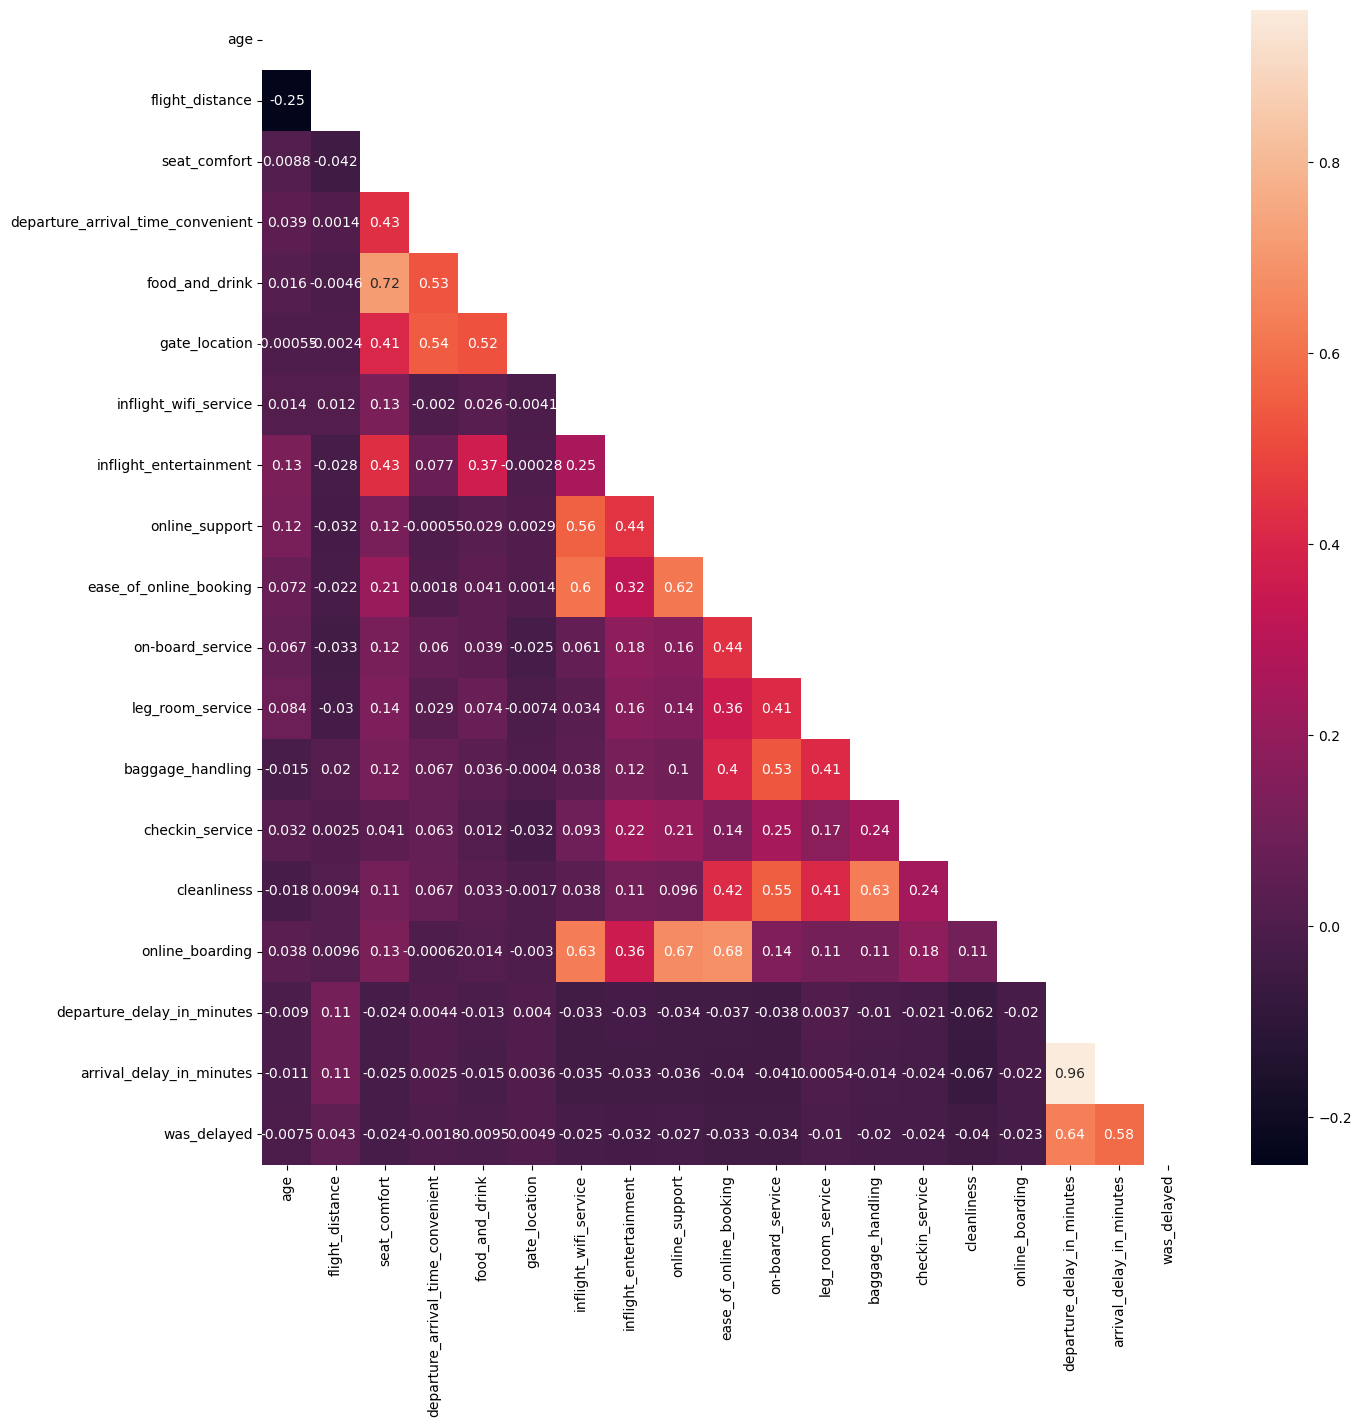

In [15]:
#Building correlation matrix

cols_corr = df.corr(numeric_only=True)
matrix = np.triu(cols_corr)

plt.figure(figsize=(15,15))
sns.heatmap(cols_corr, annot=True, mask=matrix)
plt.show()

As suspected, there is a strong positive correlation between departure delays and arrival delays. To simplify later work we will likely only need one of these columns.

There also looks to be good correlations between (amongst other things):
- Food and drink and flight distance (0.72)
- Online support and online boarding (0.68)
- Online support and ease of online booking (0.67)
- Baggage handling and cleanliness (0.63)
- On-board service and cleanliness (0.55)

It might be that some of these things are conceptually related (e.g. having good food options on a long haul flight, online services and online boarding). Others may just be consistently rated similarly by customers even if they are not actually related services (I suspect might be the case with baggage handling and  cleanliness).

These relationships may become clearer when we start looking at feature importance with machine learning later on.

### Exploration

Let's now use some data visualisation techniques to understand the distribution of satisfied/unsatisfied customers better.

I want to see the overall distribution of Satisfied vs Dissatisfied customers, and try to drill this down into subgroups or where certain likely flight features might have been impactful.

For example, how does flight distance, flight delays, customer age or customer loyalty status impact satisfaction? These are all factors that could be relevant to our later feature importance study.

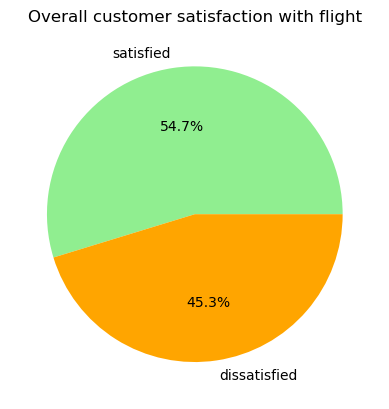

satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64


In [16]:
palette = ['lightgreen', 'orange']

#Distribution of satisfied vs dissatisfied customers
plt.pie(df['satisfaction'].value_counts(), labels=['satisfied','dissatisfied'],
       autopct='%1.1f%%', colors=palette)
plt.title('Overall customer satisfaction with flight')
plt.show()

print(df['satisfaction'].value_counts())

So at the broadest of strokes, just over half of our sample customers were satisfied with their flight. This certainly could be improved upon! Let's see how this breaks down when we look at customer loyalty.

In [17]:
#using plotly express starburst chart

fig = px.sunburst(df, path=['customer_type','satisfaction'], title='Satisfaction by Loyalty Status')

fig.update_traces(textinfo="label+percent parent")

fig.update_layout(
    autosize=False,
    height=500,
    width=500)

fig.show()

Over 80% of the customers giving feedback are loyal. The method of sampling this dataset is not given, so it might be that loyal customers are more easily convinced, motivated or contactable to give feedback. 

It might also be the case that this is a random and well-sampled dataset, which we will have to assume is the case, and the above distribution represents the actual distribution of customers flying with our airline.

Loyal customers are more likely to be satisfied with their flights, and much more likely to be satisfied than disloyal customers. <b>Over three quarters of disloyal customers were <i>not</i> satisfied. In this study, that equates to over 18,000 customer flights. This represents a huge missed oppportunity to create loyal and ongoing customers in the future.</b>


### Customer Age

We'll now have a look at how customer age and satisfaction are related.

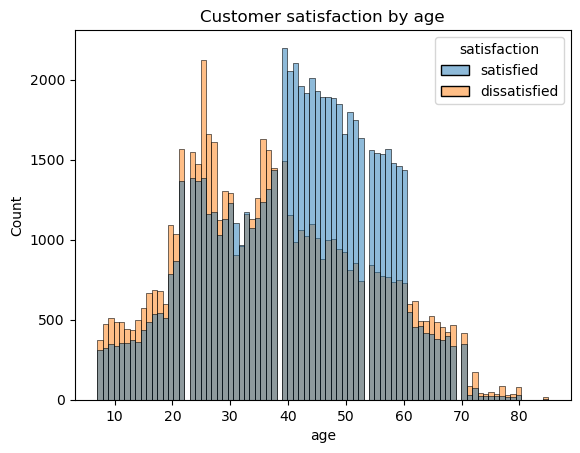

In [18]:
ax1 = sns.histplot(data=df, x=df['age'], hue=df['satisfaction'], color=palette)
plt.title('Customer satisfaction by age')
plt.show()

There is a fairly normal distribution of ages across our airline's customers. It seems that older customers are more likely to be satisfied with their experience, while younger ones skew more toward dissatisfaction.

How does customer loyalty fit into this picture?

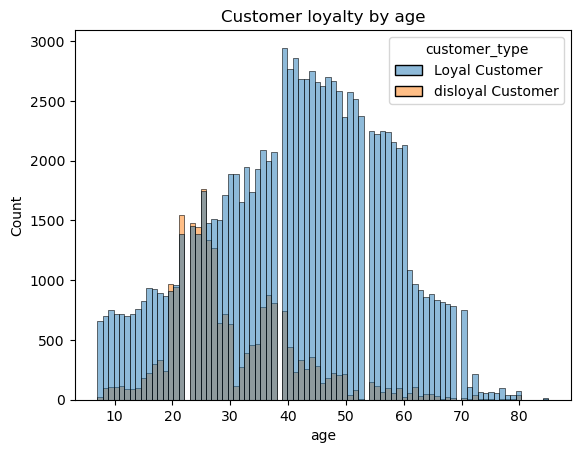

In [19]:
ax2 = sns.histplot(data=df, x=df['age'], hue=df['customer_type'], color=palette)
plt.title('Customer loyalty by age')

plt.show()

Ah! So disloyal customers are more likely to be younger, while repeat/loyal customers come from a range of ages but are predominately older.

This makes for an interesting discovery, given our understanding from the starburst plot above. Are we not appealing to the flight features desired by younger customers? Are our younger customers having or looking for a different flight experience to older ones?

I'm going to split our customers up into Older and Younger groups, based on the chart above. 40 seems like a good number for this, we can check this below.

In [20]:
younger = df['age'] <= 40
younger.value_counts()

True     67272
False    62608
Name: age, dtype: int64

A fairly even split of the data at 40 - we'll use this age as our slicing point.

In [21]:
df['age_group'] = younger == True

df['age_group'].replace({True:'Younger',False:'Older'}, inplace=True)

In [22]:
fig = px.sunburst(df, path=['age_group','customer_type','satisfaction'], title='Satisfaction by Loyalty and Age',
                 color='satisfaction')

fig.update_traces(textinfo="label+percent parent")

fig.update_layout(
    autosize=False,
    height=500,
    width=500)

fig.show()

This chart is getting a little messy but we can make do with it. Essentially, it is telling us that:

1. We have a fairly even split between the number of customers under 40 and over 40
2. In both age groups, loyalty is more common than disloyalty. However, older customers are overwhelmingly more likely to be loyal, with 94% of travelers over the age of 40 being repeat customers of ours.
3. Dissatisfaction is slightly higher for loyal younger customers than loyal older ones.


I would say from the above that age is certainly a factor influencing the likelihood of being a loyal customers, but does not necessarily have a huge impact on satisfaction. However, it does support our idea that satisfaction and loyalty themselves are very linked.

### Travel Purpose

How does customer travel type impact satisfaction? We have two travel types: Business travel and Personal travel.

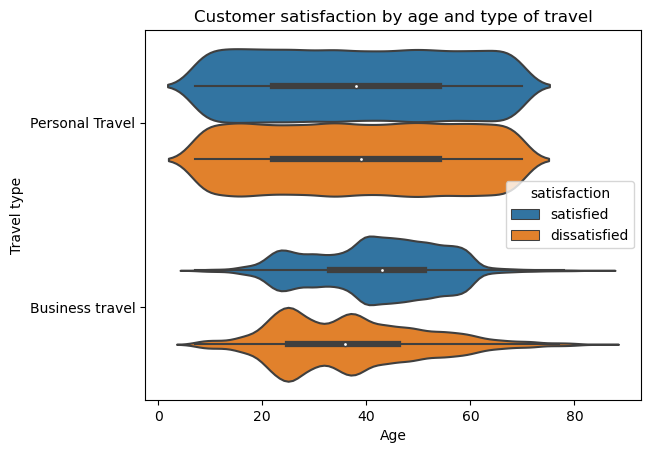

In [23]:
sns.violinplot(data=df, x=df['age'], y=df['type_of_travel'], hue=df['satisfaction'])
plt.ylabel('Travel type')
plt.xlabel('Age')
plt.title('Customer satisfaction by age and type of travel')
plt.show()

I've used a violin plot above to look at this data with a more detailed age distribution than our over 40/under 40 range. 

There is an interesting split when we look at satisfaction by age and travel type. 

Personal travelers are largely diverse and their satisfaction levels spread across the entire age range. 

Business travlers are by and large betweeen the ages of 20 and 60 (to be expected, as this aligns well with general working ages). The spread of ages seems to be fairly evenly distributed, however it is split nicely along satisfaction. Our more mature business travelers are generally more satisfied with their flight experience than younger ones. However, both groups have fairly long tails so this might not be as strong an association as a first glance indicates.

We can visualise this with our age group split to get more info.

In [24]:
fig = px.sunburst(df, path=['age_group','type_of_travel','satisfaction'], 
                  title='Satisfaction by Travel Purpose and Age')

fig.update_traces(textinfo="label+percent parent")

fig.update_layout(
    autosize=False,
    height=500,
    width=500)

fig.show()

So roughly 70% of both our under-40s and over-40s are traveling for business. The younger group of business travelers has a fairly even split between satistisfaction and dissatisfaction, and older business travelers are more satisfied overall.

Are we seeing customer loyalty in another way here, via the travel type? Rather than another messy chart, we'll look at the numbers directly.

In [25]:
pct = lambda x: round(100 * x / x.sum(),2)

business_loyalty = df.groupby('customer_type')[['type_of_travel', 'satisfaction']].value_counts()
business_loyalty_2 = business_loyalty.groupby(['customer_type','type_of_travel'], group_keys=False).apply(pct)


print('Raw Figures:\n {}'.format(business_loyalty))
print('\n\n')
print('As Percentages:\n {}'.format(business_loyalty_2))

Raw Figures:
 customer_type      type_of_travel   satisfaction
Loyal Customer     Business travel  satisfied       46688
                   Personal Travel  dissatisfied    21287
                   Business travel  dissatisfied    19426
                   Personal Travel  satisfied       18699
disloyal Customer  Business travel  dissatisfied    17911
                                    satisfied        5668
                   Personal Travel  dissatisfied      169
                                    satisfied          32
dtype: int64



As Percentages:
 customer_type      type_of_travel   satisfaction
Loyal Customer     Business travel  satisfied       70.62
                   Personal Travel  dissatisfied    53.24
                   Business travel  dissatisfied    29.38
                   Personal Travel  satisfied       46.76
disloyal Customer  Business travel  dissatisfied    75.96
                                    satisfied       24.04
                   Personal Travel  dissati

Note on above: the percentages above are calculated per subgroup, i.e between disloyal personal travelers, we've calculated the percent of dissatisfied vs satisfied customers.

It seems like leisure/personal travel customers are almost guaranteed to be loyal. The raw figures show us that there are very few leisure travelers who are not part of our loyalty scheme already. 

In our sample data, business customers are more likely than not to be loyal (approx. 66,000) but there is still a sizeable proportion of business travelers who are not part of our loyalty scheme (approx. 23,000).

Interestingly, amongst the business traveling customers, regardless of loyalty it seems that the percentage of satisfied customers stays around 70-75%.

Loyal personal travelers seem harder to please in this regard - they have a split of around the 50/50 mark.

From this analysis, I would suggest <b>it would be worth focusing on bringing some of the disloyal business travelers into the loyalty scheme by improving their satisfaction, and looking at ways to improve the experience overall for personal travelers.</b>

### Flight Delays

We'll look now at whether delayed flights impact satisfaction, and to what extent.

We earlier created a column called 'was_delayed' which is True for flights with a departure delay time of greater than the mean of approx. 15 minutes. We'll use this column in our analysis.

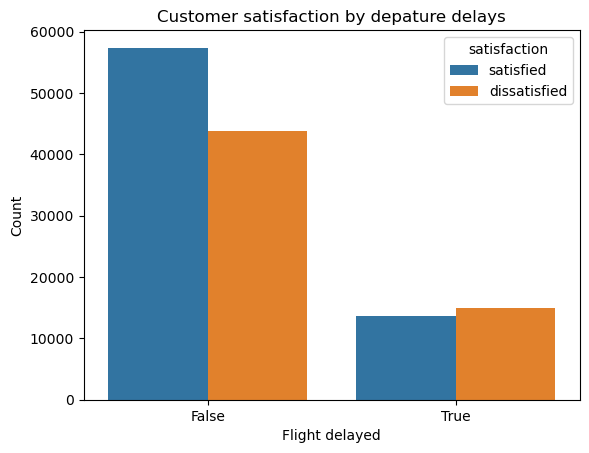

In [26]:
sns.countplot(data=df, x='was_delayed', hue='satisfaction')
plt.ylabel('Count')
plt.xlabel('Flight delayed')
plt.title('Customer satisfaction by depature delays')
plt.show()

The above chart measures counts, and we have fewer flights delayed in our dataset than not delayed. Looking at the flight delayed 'True' columns, customers are just slightly more likely to be dissatisfied than satisfied with their overall experience.

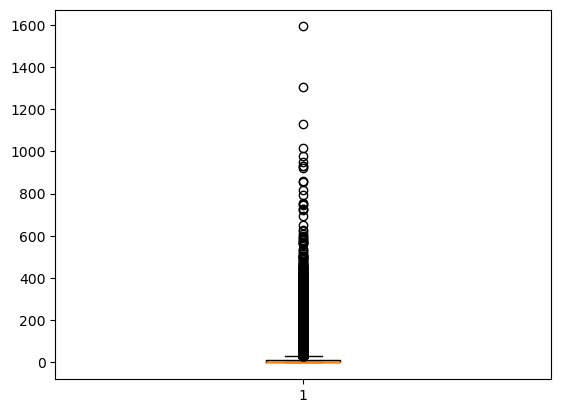

In [27]:
plt.boxplot(df['departure_delay_in_minutes'])
plt.show()

Flight departure delays do not seem to have largely impacted satisfaction. It looks like the majority of delays are short, with the mean at 14 mins, and we have numerous outliers when looking at the boxplot. It is likely that small delays are not too troublesome for customers.

Does this change when we look at longer delay times?

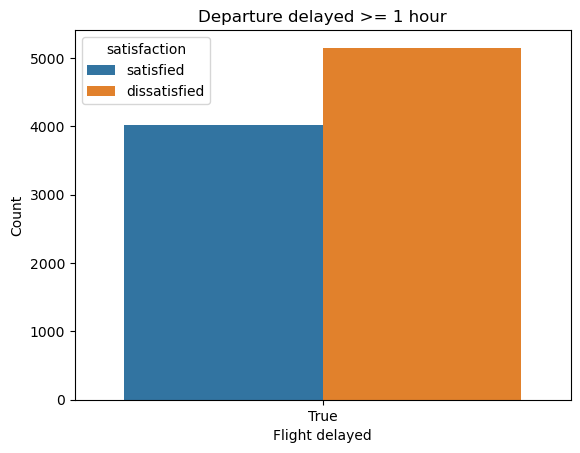

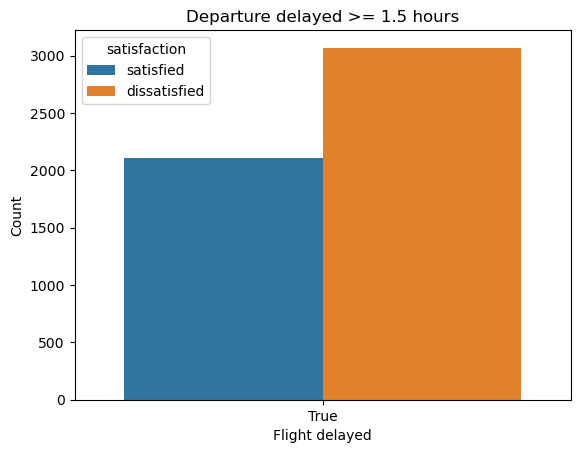

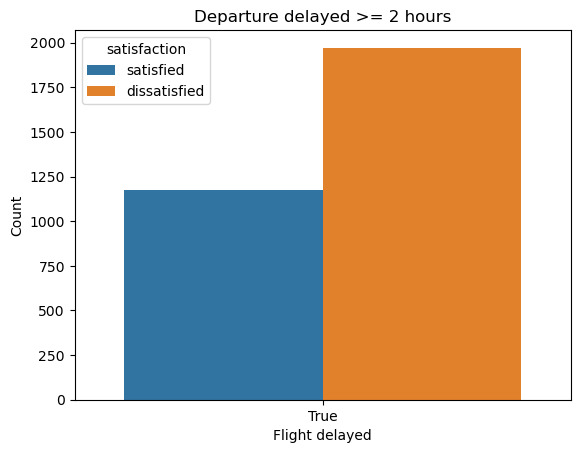

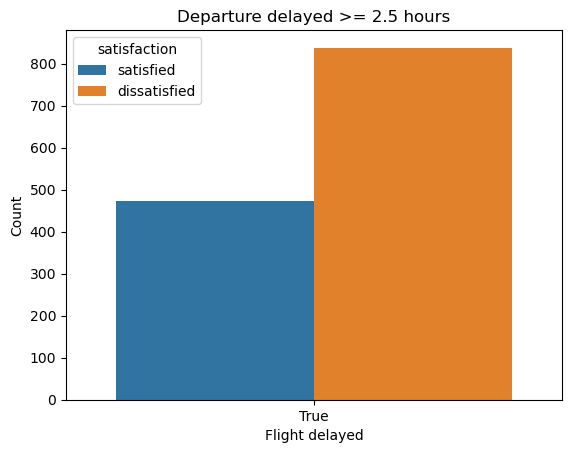

In [28]:
longer_delays = df[df['departure_delay_in_minutes'] >= 120]

ax1 = sns.countplot(data=df[df['departure_delay_in_minutes'] >= 60], x='was_delayed', hue='satisfaction')
plt.ylabel('Count')
plt.xlabel('Flight delayed')
plt.title('Departure delayed >= 1 hour')
plt.show()

ax2 = sns.countplot(data=df[df['departure_delay_in_minutes'] >= 90], x='was_delayed', hue='satisfaction')
plt.ylabel('Count')
plt.xlabel('Flight delayed')
plt.title('Departure delayed >= 1.5 hours')
plt.show()

ax3 = sns.countplot(data=df[df['departure_delay_in_minutes'] >= 120], x='was_delayed', hue='satisfaction')
plt.ylabel('Count')
plt.xlabel('Flight delayed')
plt.title('Departure delayed >= 2 hours')
plt.show()

ax4 = sns.countplot(data=df[df['departure_delay_in_minutes'] >= 180], x='was_delayed', hue='satisfaction')
plt.ylabel('Count')
plt.xlabel('Flight delayed')
plt.title('Departure delayed >= 2.5 hours')

plt.show()

<b>As flight delays get longer, there is an increase in the number of dissatisfied customers.</b>

This gels well with common sense. <b> Reducing delays as much as possible will aid in improving overall satisfaction</b>


We'll now move on to having a look at the customer ratings for each flight feature. Recall that a flight feature includes things like legroom, gate location, food and drink, and pre- or post-flight services such as online booking and baggage handling.

### Which features have the best and worst customer satisfaction?

We'll take a quick look first at customer ratings for each service, then do the same but differentiating by satisfied vs dissatisfied customers.

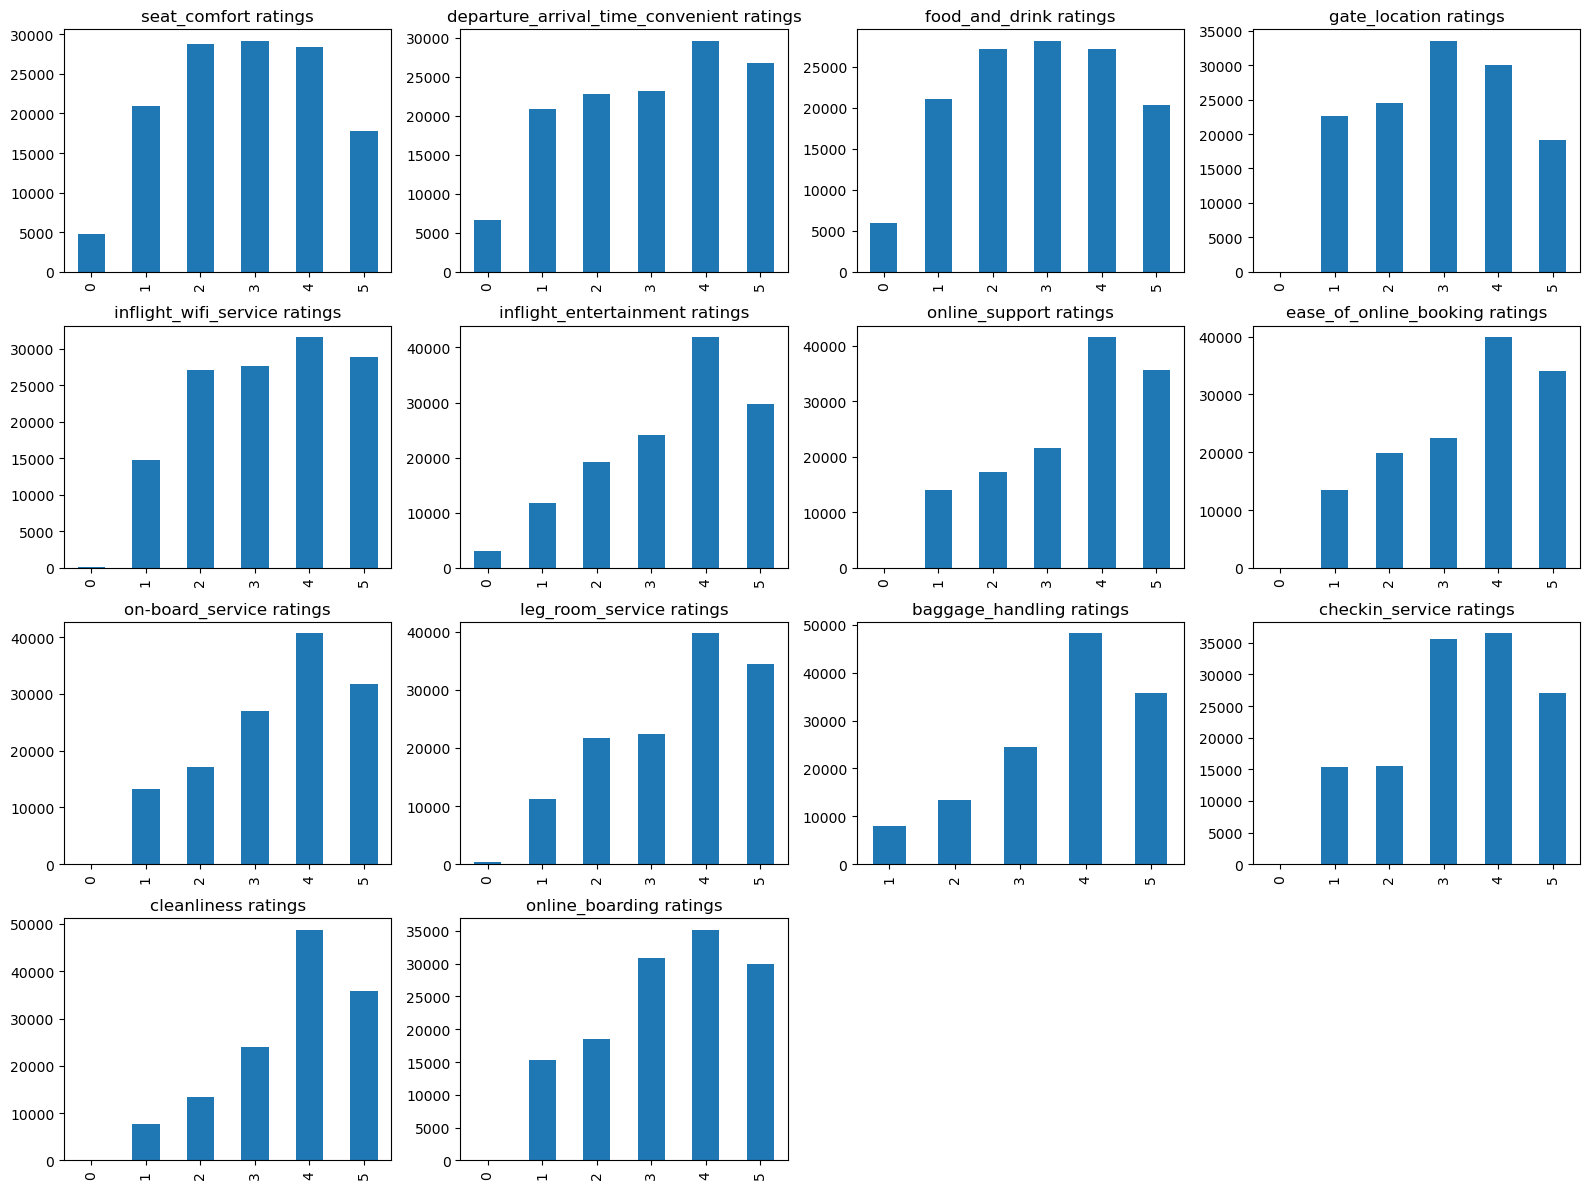

In [29]:
fig = plt.figure(2,figsize=(16,12))


for i, col in enumerate(rating_cols,1):
    fig.add_subplot(4,4,i)
    df[col].value_counts().sort_index().plot(kind='bar',ax=plt.gca())
    plt.title(col + ' ratings')
plt.tight_layout()
plt.show(1)

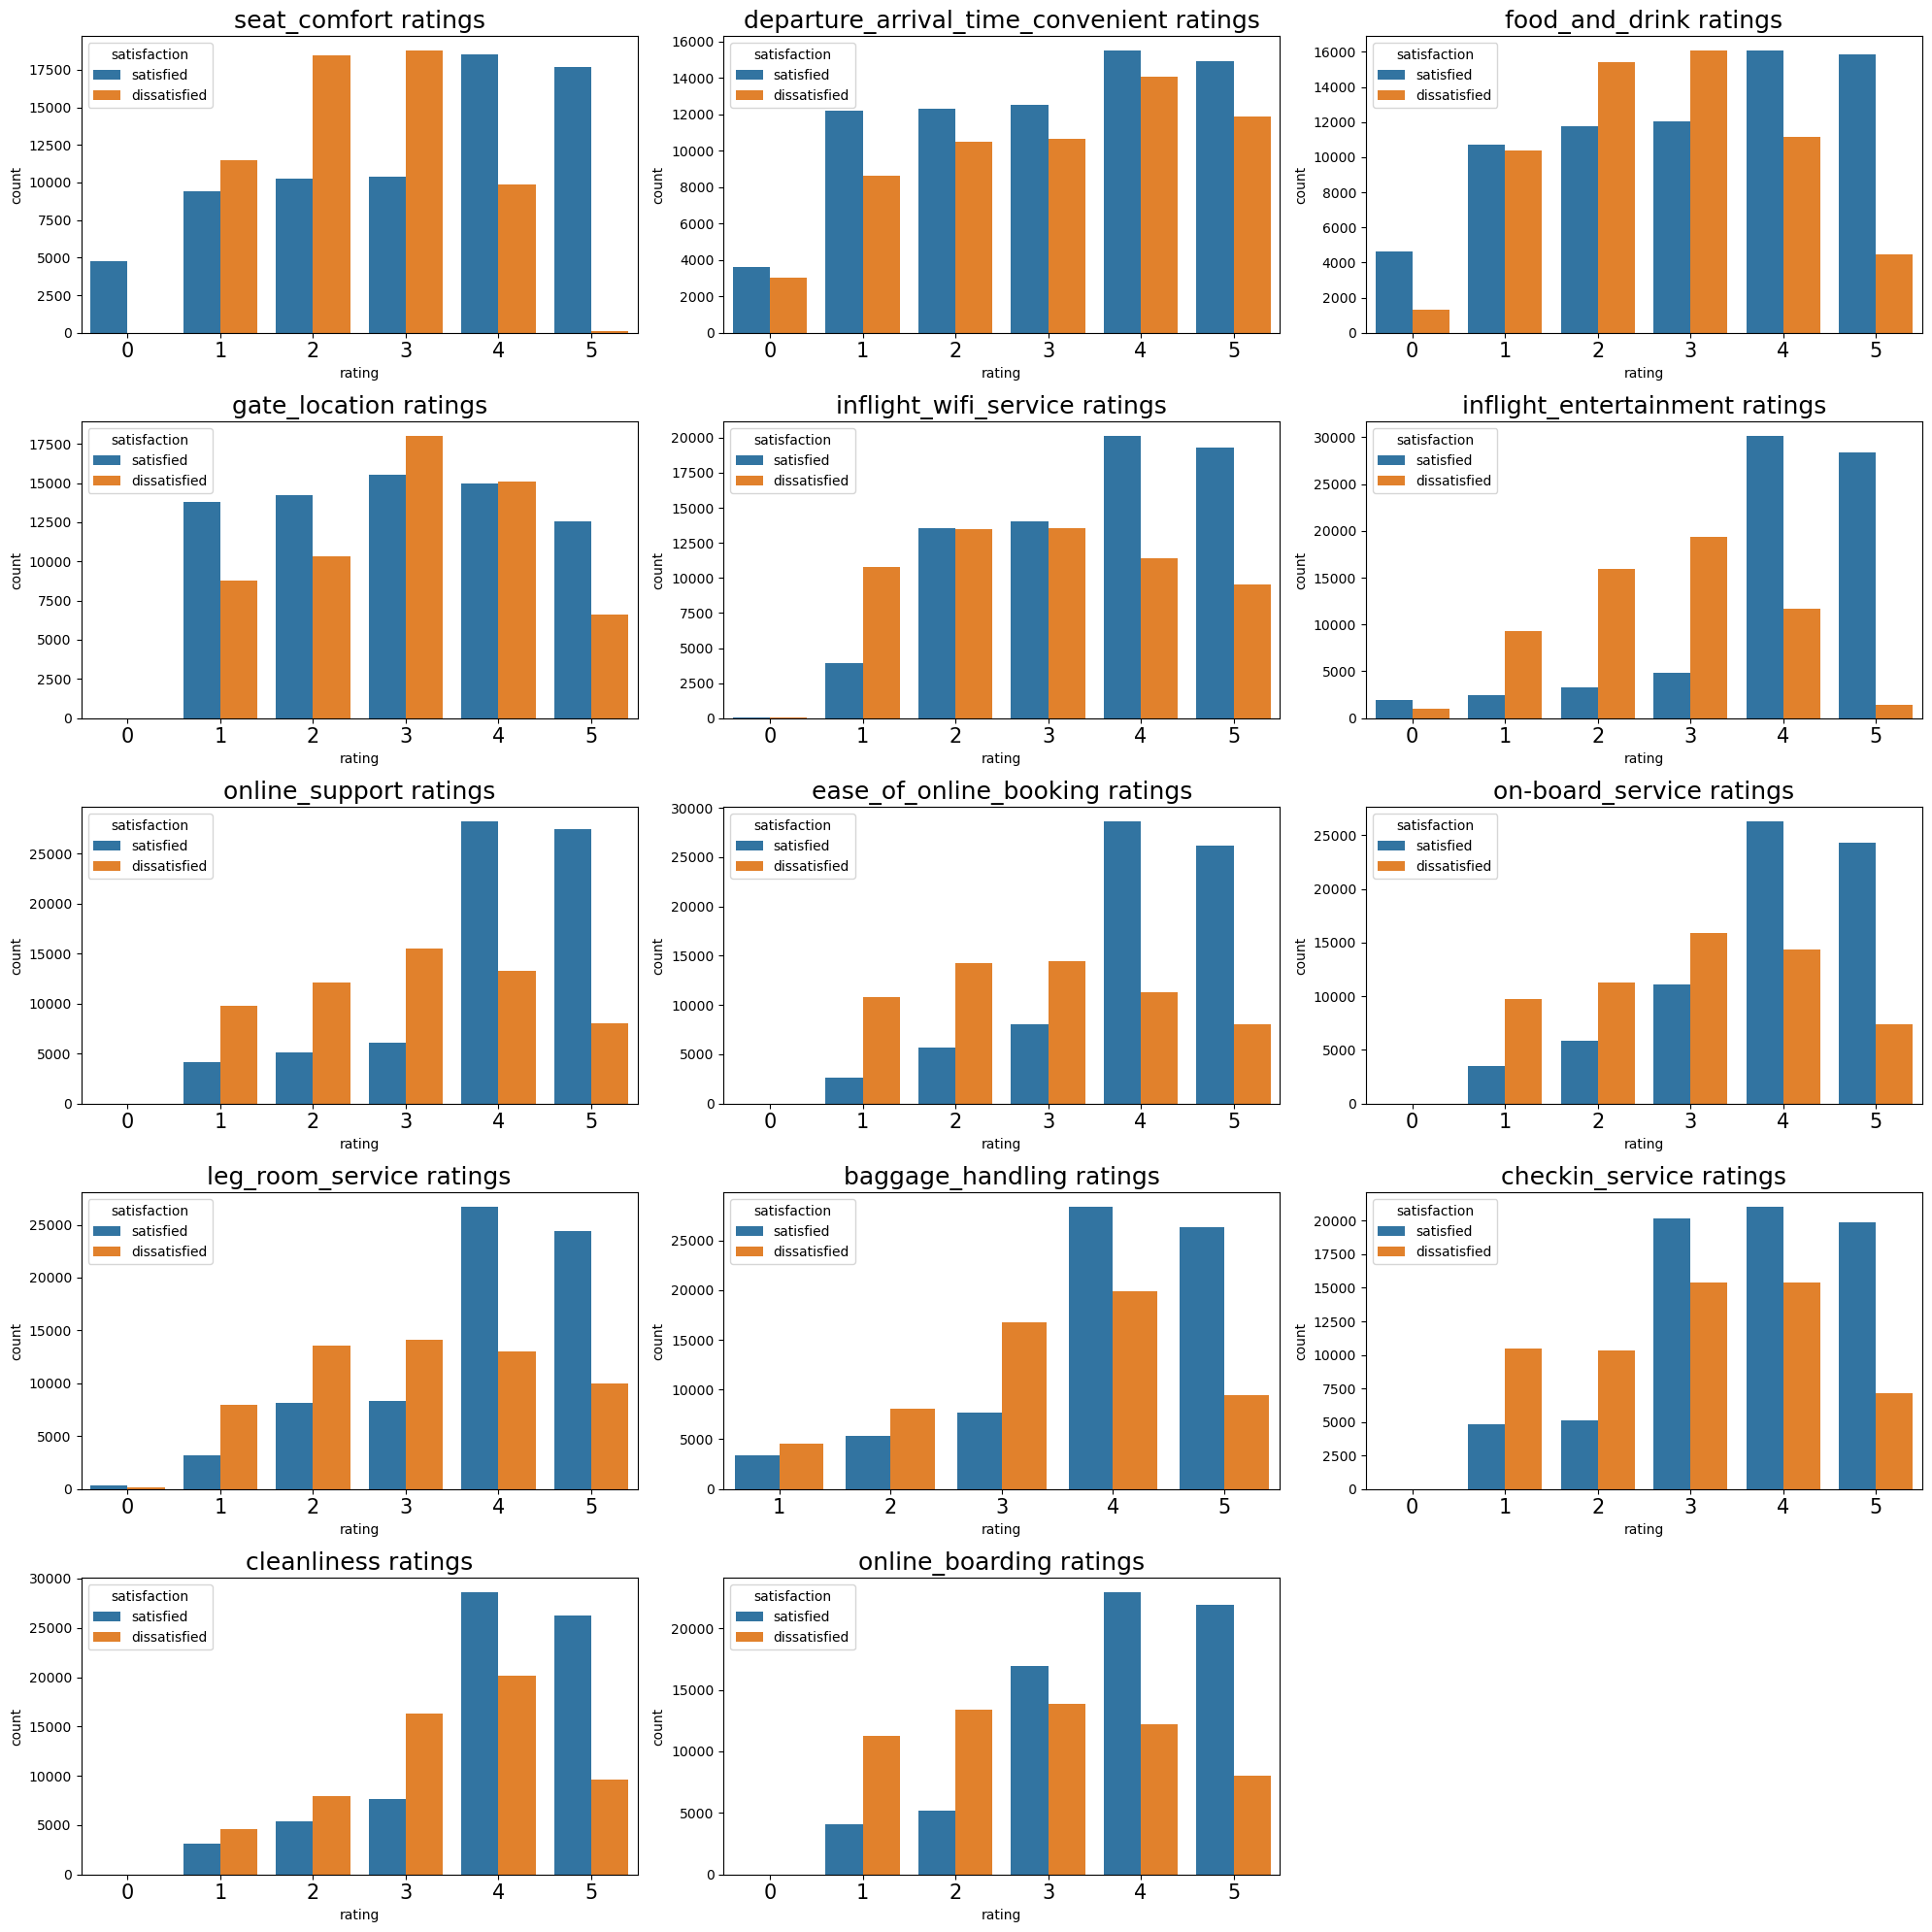

In [30]:
fig = plt.figure(2,figsize=(20,20))

for i, col in enumerate(rating_cols,1):
    fig.add_subplot(5,3,i)
    sns.countplot(data=df, x=df[col], hue='satisfaction')
    plt.title(col + ' ratings', size=18)
    plt.xlabel('rating')
    plt.xticks(size=15)
plt.tight_layout()
plt.savefig('satisfaction_and_ratings.jpg')
plt.show(1)

Above, we have plotted the count of each rating given by customers for each of the relevant flight features. These counts are divided by satisfied and dissatisfied customers. 

Let's take a closer look at the charts.

Areas where there is little substantial difference between the two groups of customers:
- convenience of the departure and arrival times
- gate location

There are many areas where satisfied customers are very happy, dissatisfied customers are mixed or unhappy. To help us unpick these areas, we'll use boxplots. The width of the boxes will tell us how distributed the ratings are (i.e. how varied the customers responses are), and the location of the boxes will tell us overall how we did for each service.

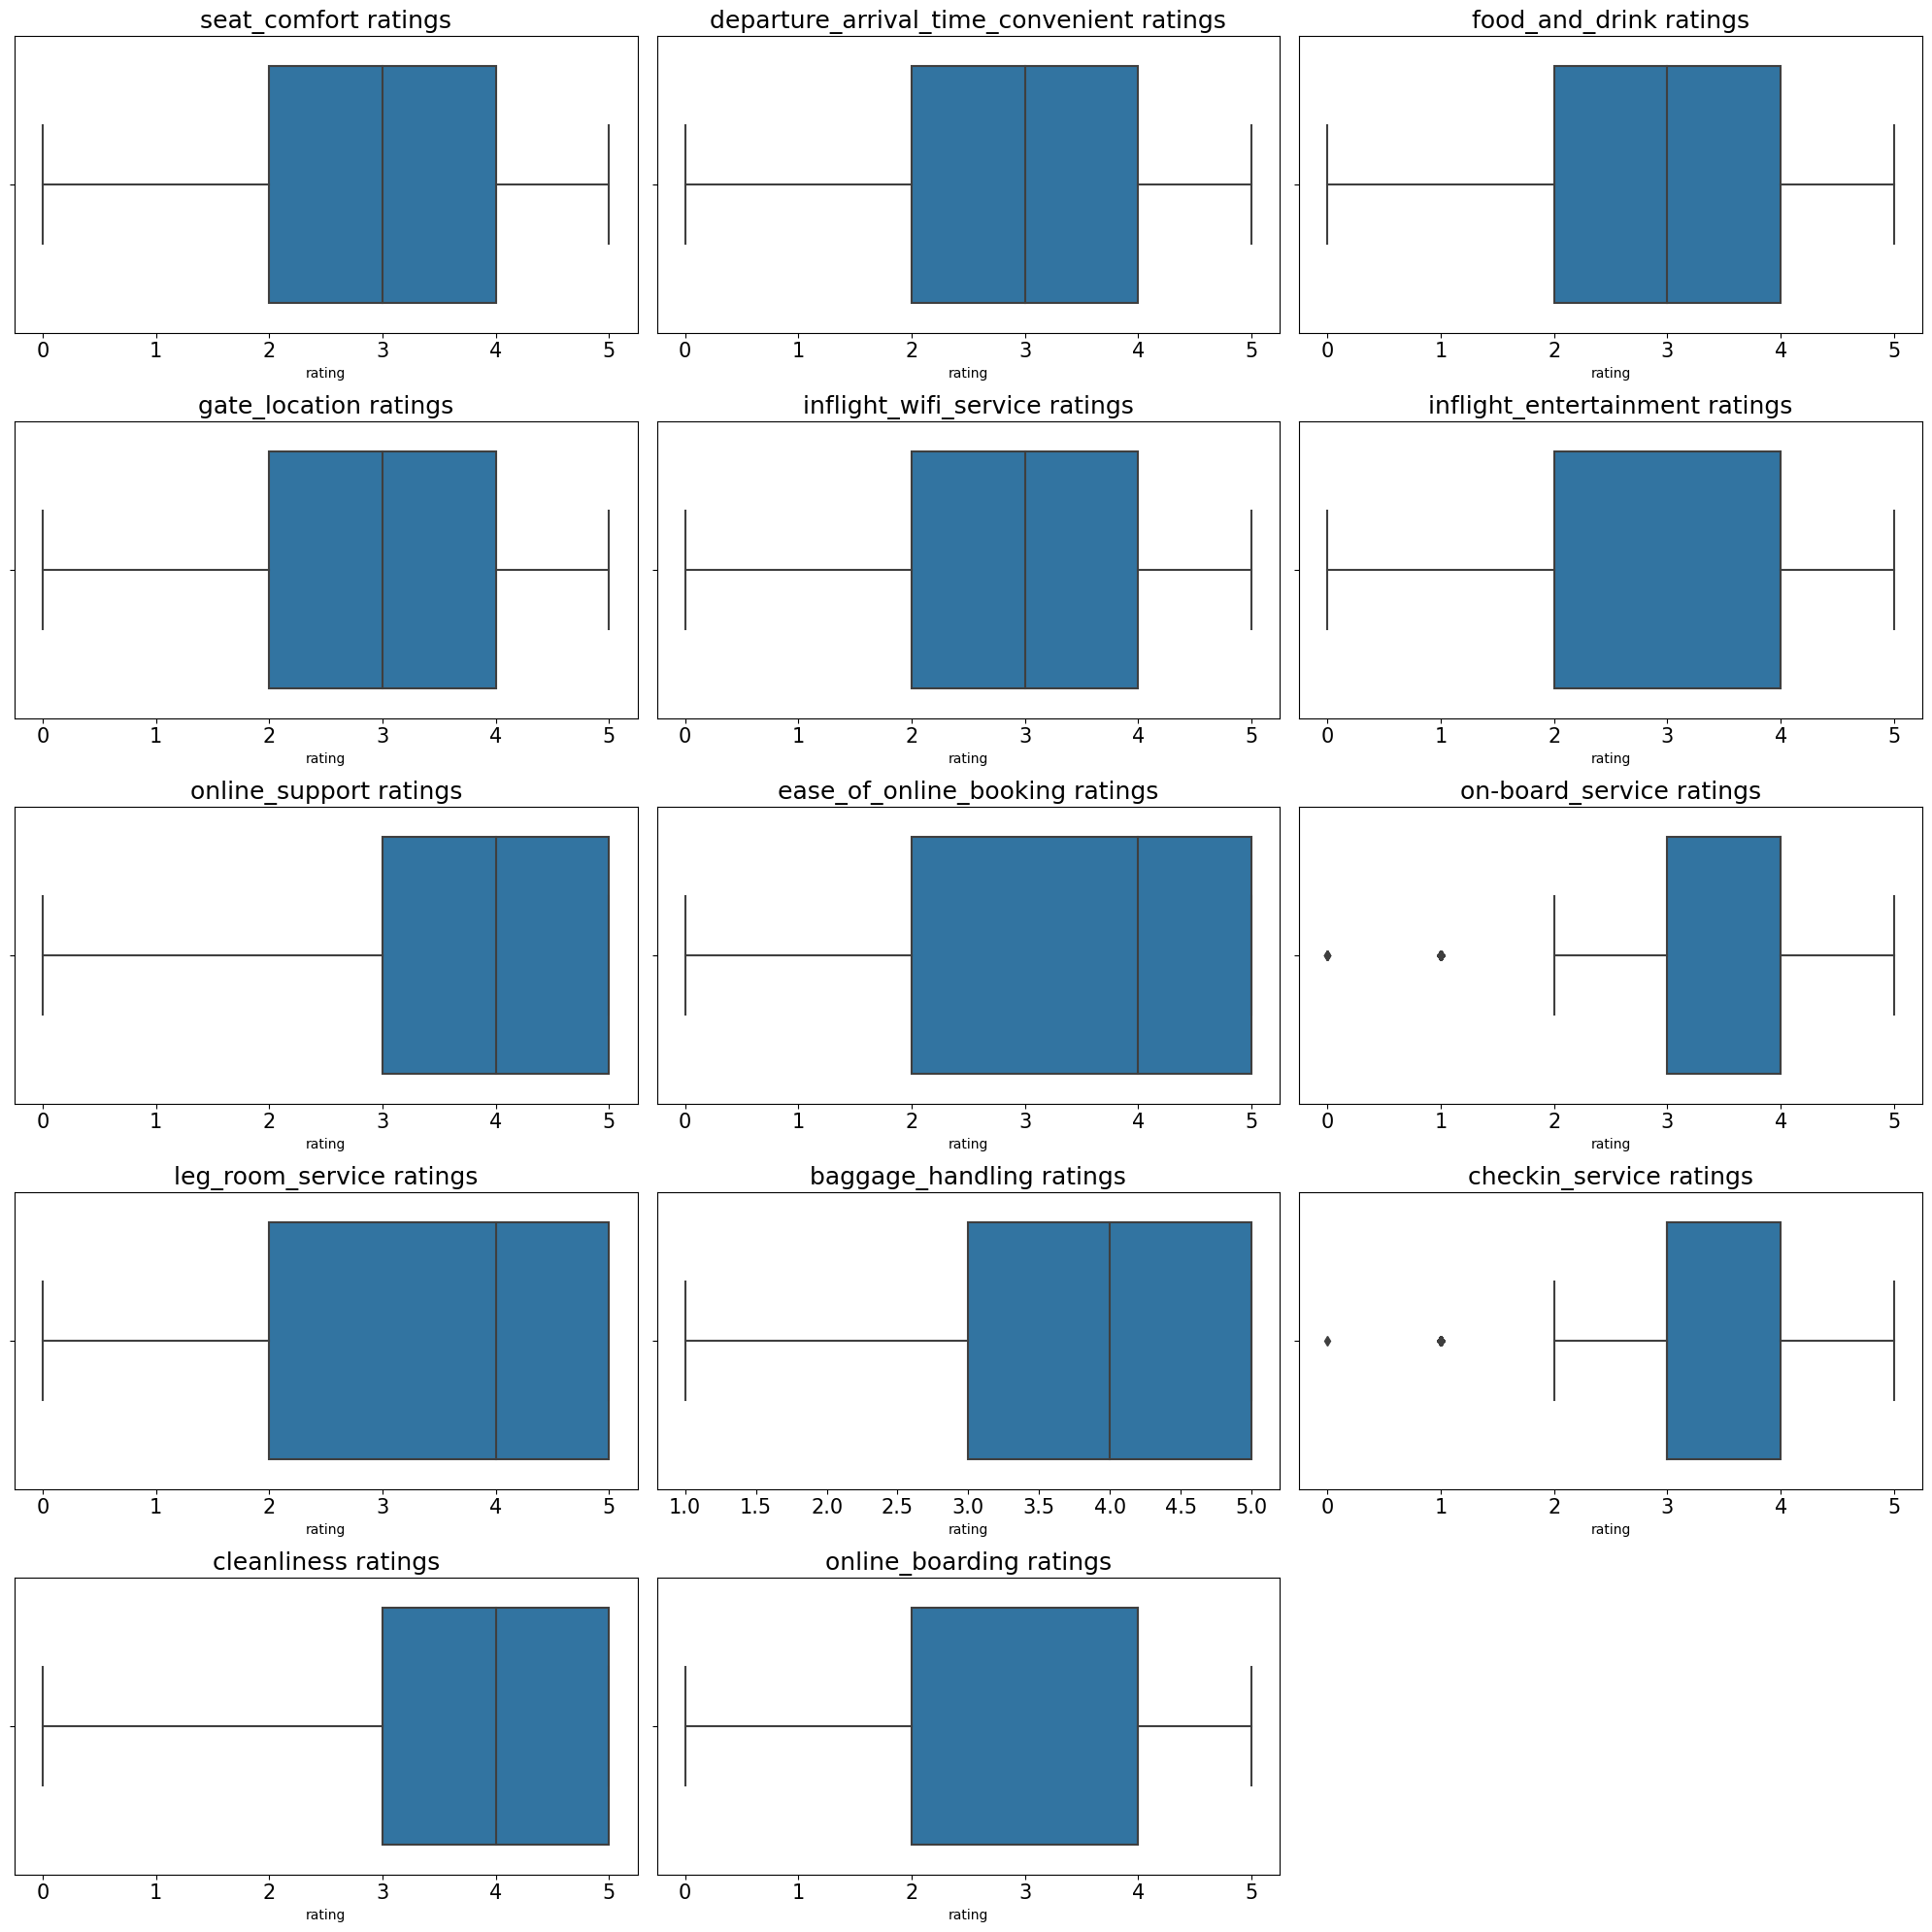

In [31]:
fig = plt.figure(2,figsize=(20,20))

for i, col in enumerate(rating_cols,1):
    fig.add_subplot(5,3,i)
    sns.boxplot(data=df, x=df[col])
    plt.title(col + ' ratings', size=18)
    plt.xlabel('rating')
    plt.xticks(size=15)
plt.tight_layout()
plt.savefig('satisfaction_and_ratings.jpg')
plt.show(1)

Boxes sitting strongly to the right include cleanliness, online support and baggage handling. Leg room and ease of online booking also trend to the right but are quite wide, indicating some variation in the responses. On board service and cehck in services are showing low ratings (0 or 1) as outliers, indicating by and large that they are well received, although not as highly received as services where the box is itself further to the right.

As a last look at the data, we'll do a simple count of the top and bottom 5 services by ratings. We'll use 4 or 5 as our 'highly rated' values, and 0 or 1 as our 'low rated' values. Ratings of 2 of 3 we'll consider average and ignore.

In [32]:
highly_rated_services = df[df.iloc[:,7:-3] >= 4]
highly_rated_services.iloc[:,7:-2].fillna(0).sum().sort_values(ascending=False).nlargest(5)

departure_delay_in_minutes    1894020.0
cleanliness                    374760.0
baggage_handling               371700.0
online_support                 343855.0
leg_room_service               330717.0
dtype: float64

In [33]:
low_rated_services = df[df.iloc[:,7:-3] <= 1]
low_rated_services.iloc[:,7:-2].fillna(0).sum().sort_values(ascending=False).nlargest(5)

gate_location                        22565.0
food_and_drink                       21076.0
seat_comfort                         20949.0
departure_arrival_time_convenient    20828.0
checkin_service                      15369.0
dtype: float64

These counts are supported by the analysis above. Cleanliness was thought to be one of the better rated services, and we can see above that it is our top rated service across flights. Services rated the lowest are gate location, food and drink, seat comfort, check in and the convenience of departure/arrival times.

The above tells us which services are rated lowest or highest, but we don't know to what extend each service is impacting our customer satisfaction. 

<b>Although low rated, would improving (say) gate locations or food and drink really make a difference on satisfaction levels overall? Where should we best invest our energy and money?</b>

We can use machine learning to answer this question.

## Which features can most impact satisfaction?

We'll now use machine learning to better understand which features most impact customer satisfaction.

As this is a classification problem, we'll see how successfully the data can be predicted using the following supervised machine learning tools:

- logistic regression
- random forest

### Preprocessing

- Dropping unnecessary columns
- Processing columns as needed, some encoding required

In [34]:
#dropping unncessary columns
df = df.drop(columns=['arrival_delay_in_minutes'])

#we're keeping the departure_delay_in_minutes column. We saw earlier these columns are very well correlated.

In [35]:
df.head(3)

satisfaction  gender   customer_type  age   type_of_travel     class  \
0    satisfied  Female  Loyal Customer   65  Personal Travel       Eco   
1    satisfied    Male  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Female  Loyal Customer   15  Personal Travel       Eco   

   flight_distance  seat_comfort  departure_arrival_time_convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   

   food_and_drink  ...  ease_of_online_booking  on-board_service  \
0               0  ...                       3                 3   
1               0  ...                       3                 4   
2               0  ...                       2                 3   

   leg_room_service  baggage_handling  checkin_service  cleanliness  \
0                 0                 3                5            3   
1                 4                 4                2            3   
2                 3                 4                4            4   

   online_boarding  departure_delay_in_minutes  was_delayed  age_group  
0                2                           0        False      Older  
1                2                         310         True      Older  
2                2                           0        False    Younger  

[3 rows x 24 columns]

In [36]:
df_processed = df.copy(deep=True)

In [37]:
#Separating columns by data type
binary_cols = df_processed[['satisfaction', 'gender', 'type_of_travel'
                            , 'was_delayed', 'customer_type', 'age_group']]
category_cols = df_processed[['class']]
numeric_cols = df_processed[['age','flight_distance','departure_delay_in_minutes']]
ordinal_cols = df_processed.iloc[:,7:-3]

In [38]:
#Encoding necessary columns, importing encoders
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

lb, le = LabelBinarizer(), LabelEncoder()

In [39]:
#ordinals - may not be needed as most are already 1-5
#but one column was 0-5 so doing it to be sure all columns match up
for column in ordinal_cols:
    df_processed[column] = le.fit_transform(df[column])

In [40]:
#binaries
for column in binary_cols:
    df_processed[column] = lb.fit_transform(df[column])

In [41]:
#scaling numeric values
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

df_processed[['age']] = mm.fit_transform(df_processed[['age']])
df_processed[['flight_distance']] = mm.fit_transform(df_processed[['flight_distance']])
df_processed[['departure_delay_in_minutes']] = mm.fit_transform(df_processed[['departure_delay_in_minutes']])

In [42]:
#one-hot encoding the class category column
ohot = pd.get_dummies(df_processed['class'])
df_processed = df_processed.drop(columns=['class'])
df_processed = df_processed.join(ohot)

In [43]:
df_processed.head(4)

satisfaction  gender  customer_type       age  type_of_travel  \
0             1       0              0  0.743590               1   
1             1       1              0  0.512821               1   
2             1       0              0  0.102564               1   
3             1       0              0  0.679487               1   

   flight_distance  seat_comfort  departure_arrival_time_convenient  \
0         0.031155             0                                  0   
1         0.349804             0                                  0   
2         0.302565             0                                  0   
3         0.083031             0                                  0   

   food_and_drink  gate_location  ...  baggage_handling  checkin_service  \
0               0              2  ...                 2                5   
1               0              3  ...                 3                2   
2               0              3  ...                 3                4   
3               0              3  ...                 0                4   

   cleanliness  online_boarding  departure_delay_in_minutes  was_delayed  \
0            3                2                    0.000000            0   
1            3                2                    0.194724            1   
2            4                2                    0.000000            0   
3            1                3                    0.000000            0   

   age_group  Business  Eco  Eco Plus  
0          0         0    1         0  
1          0         1    0         0  
2          1         0    1         0  
3          0         0    1         0  

[4 rows x 26 columns]

I actually don't need all the values that I scaled, but it's handy to have it done in case we want to play with them later. For the time being, w're going to be looking at which of the features in the rating columns were most impactful on customer satisfaction. So, we'll just use the ordinal columns.

As a reminder for our satisfaction column:<br>
1 = satisfied
0 = dissatisfied

In [44]:
df_ratings = df_processed.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed','Business',
                              'Eco','Eco Plus', 'age_group'])

In [45]:
df_ratings.head(1)

satisfaction  seat_comfort  departure_arrival_time_convenient  \
0             1             0                                  0   

   food_and_drink  gate_location  inflight_wifi_service  \
0               0              2                      2   

   inflight_entertainment  online_support  ease_of_online_booking  \
0                       4               2                       3   

   on-board_service  leg_room_service  baggage_handling  checkin_service  \
0                 3                 0                 2                5   

   cleanliness  online_boarding  
0            3                2

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

We'll look firstly at Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

# Set up X and y variables
y, X = df_ratings['satisfaction'], df_ratings.drop(columns='satisfaction')

# fit a model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_ratings.satisfaction, random_state=1)
logreg = LogisticRegression(C=100, max_iter=1000).fit(X_train, y_train)

print('Training set score: {:3f}'.format(logreg.score(X_train,y_train)))
print('Test set score: {:.3f}'.format(logreg.score(X_test,y_test)))

Training set score: 0.806663
Test set score: 0.806


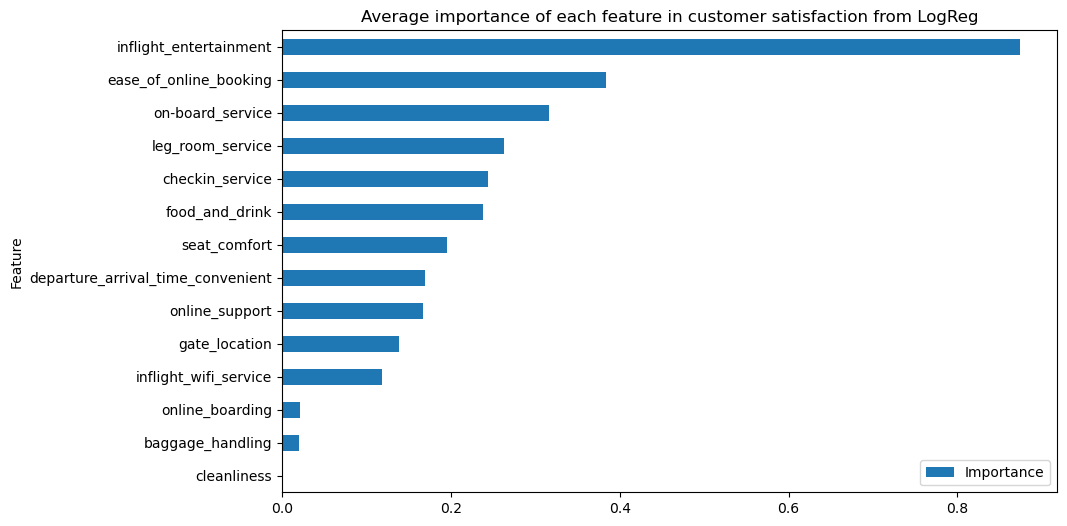

In [48]:
coefficients = logreg.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Average importance of each feature in customer satisfaction from LogReg')
plt.legend(loc='lower right')
plt.show()

This model isn't that accurate - a score of 0.80 is OK but we can probably do better.

Nevertheless, a quick glance at the results above is quite interesting. The model has predicted that inflight_entertainment is by far the most important service when it comes to customer satisfaction, while cleanliness hardly ranks at all. Remember that cleanliness was our <i>best rated service overall</i>, yet it seems to have little bearing on satisfaction (at least in this model). 

Perhaps all our customers are fairly equally impressed by our cleanliness, so it does little to predict if someone is going to be overall satisfied with us.

To investigate this claim, I've plotted the ratings for both inflight_entertainment and cleanlineness again below to look at this more closely.

Recall that 1 = satisfied and 0 = dissatisfied

For inflight_entertainment, there is a very distinct difference between the satisfied (1) group and the dissatisfied (0) group's ratings. This distinction is weaker for cleanliness. It's likely these differences have impacts the feature importance. According to this model, when a customer likes the inflight_entertainment, they <i>really</i> like it!

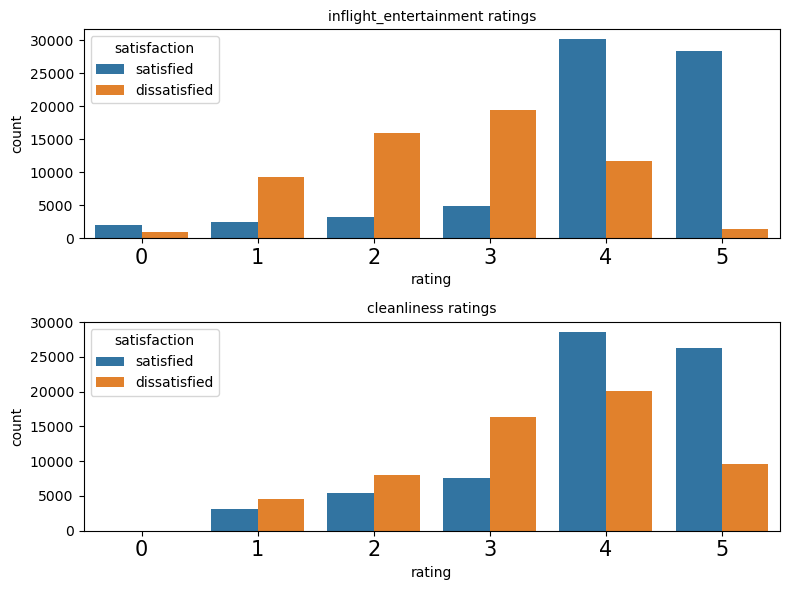

In [49]:
fig = plt.figure(2,figsize=(8,6))

plot_cols = ['inflight_entertainment', 'cleanliness']

for i, col in enumerate(plot_cols,1):
    fig.add_subplot(2,1,i)
    sns.countplot(data=df, x=df[col], hue='satisfaction')
    plt.title(col + ' ratings', size=10)
    plt.xlabel('rating')
    plt.xticks(size=15)
plt.tight_layout()
plt.savefig('satisfaction_and_ratings.jpg')
plt.show(1)

We'll turn now to Random Forest to see if we can get a more accurate model to use.

In [50]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

# Set up X and y variables
y, X = df_ratings['satisfaction'], df_ratings.drop(columns='satisfaction')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_ratings.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [51]:
print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

Accuracy on training set: 0.996
Accuracy on test set: 0.948


This is a much better score than the logistic regression model earlier.

We want to see which features are seen as most important to the model. For Random Forest, we'll use Mean Decrease in Impurity (MDI). This is <i>the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble. </i>([Source](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3))

In [52]:
rating_list = list(df_ratings.drop(columns='satisfaction').columns)

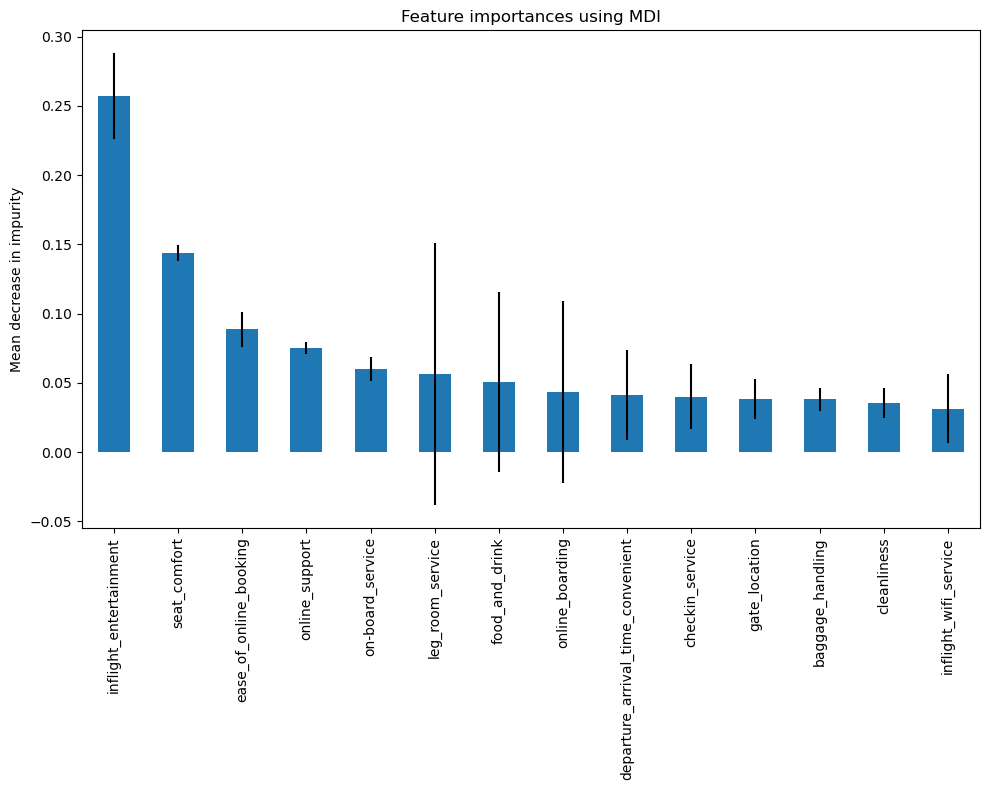

In [53]:
#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = forest.feature_importances_

forest_importances = pd.Series(importances, index=rating_list).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The Random Forest algorithm has also selected inflight_entertainment as the most important service to distinguish a satisfied from a dissatisfied customer. Seat comfort also features quite highly, alongside some online services, while the remainder of features are of diminishing importance.

We saw earlier that the reason for travel has an impact on customer satisfaction. It would be interesting to see if there is a difference in how this model looks for business vs personal travelers.

In [54]:
#setting up the Random Forest Model for business travelers
# Set up X and y variables

business = df[df['type_of_travel'] == 'Business travel']
personal = df[df['type_of_travel'] == 'Personal Travel']

In [55]:
business.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed', 'class', 'age_group'], inplace=True)

personal.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed', 'class', 'age_group'], inplace=True)

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/943496213.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/943496213.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
y, X = business['satisfaction'], business.drop(columns=['satisfaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=business.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=300, random_state=1)
forest.fit(X_train,y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

Accuracy on training set: 0.996
Accuracy on test set: 0.953


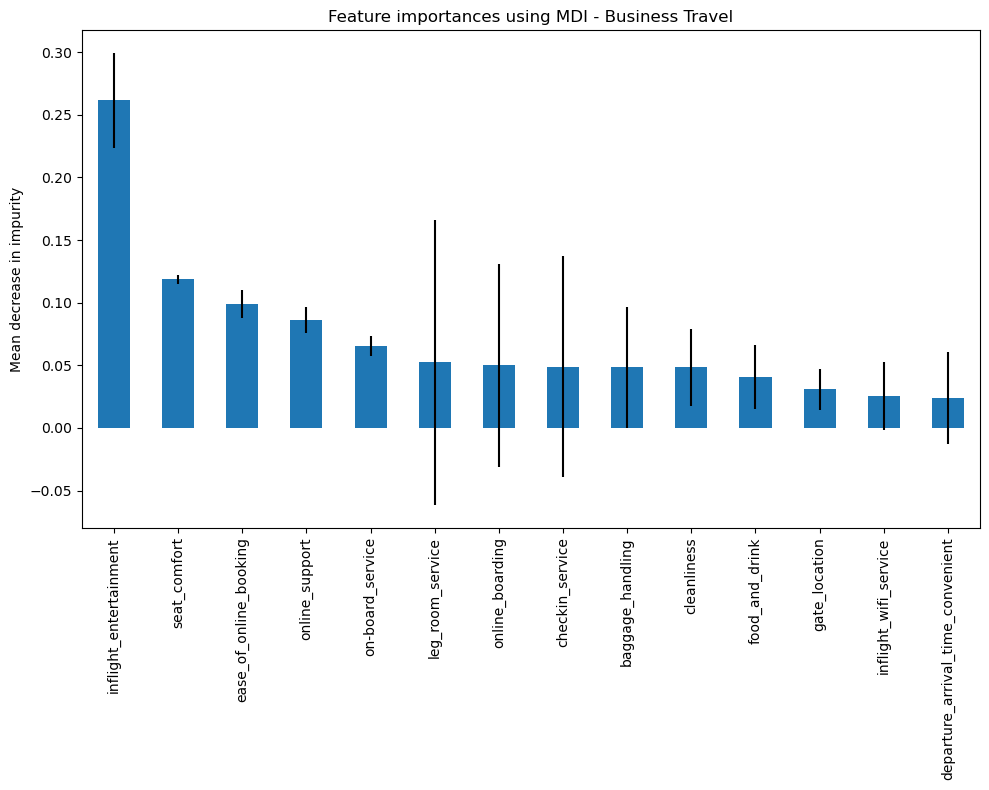

In [57]:
#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = forest.feature_importances_

forest_importances_business = pd.Series(importances, index=rating_list).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances_business.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI - Business Travel")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [58]:
y, X = personal['satisfaction'], personal.drop(columns=['satisfaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=personal.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=300, random_state=1)
forest.fit(X_train,y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Accuracy on training set: 0.998
Accuracy on test set: 0.943


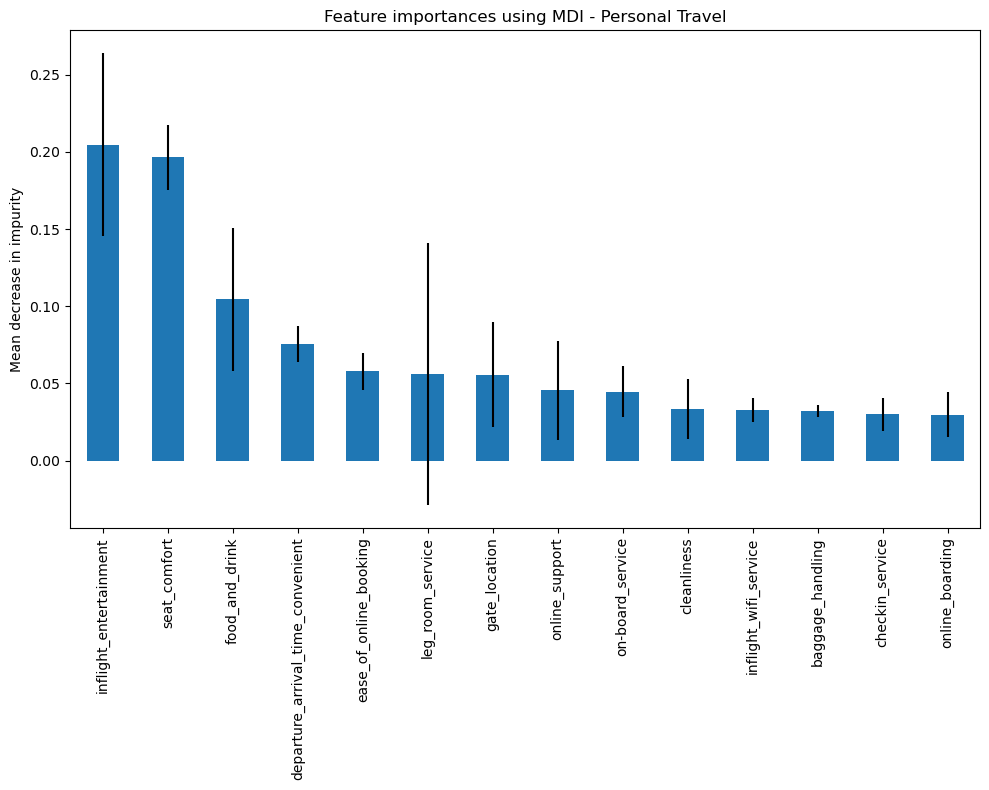

In [59]:
importances = forest.feature_importances_

forest_importances_personal = pd.Series(importances, index=rating_list).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances_personal.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI - Personal Travel")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [60]:
imp_business = pd.DataFrame(forest_importances_business).reset_index().rename(columns={'index':'service'
                                                                                       ,0:'importance'})
imp_personal = pd.DataFrame(forest_importances_personal).reset_index().rename(columns={'index':'service'
                                                                                       ,0:'importance'})
imp_travel_reasons = imp_business.merge(right=imp_personal, how='outer'
                                        , left_on='service'
                                        , right_on='service'
                                        , suffixes=('_bus','_per'))
imp_travel_reasons

service  importance_bus  importance_per
0              inflight_entertainment        0.261585        0.204795
1                        seat_comfort        0.118552        0.196617
2              ease_of_online_booking        0.098595        0.057973
3                      online_support        0.086274        0.045627
4                    on-board_service        0.065204        0.044667
5                    leg_room_service        0.052384        0.056084
6                     online_boarding        0.050105        0.029661
7                     checkin_service        0.049051        0.030132
8                    baggage_handling        0.048518        0.032223
9                         cleanliness        0.048296        0.033594
10                     food_and_drink        0.040728        0.104636
11                      gate_location        0.031018        0.055606
12              inflight_wifi_service        0.025534        0.032883
13  departure_arrival_time_convenient        0.024155        0.075501

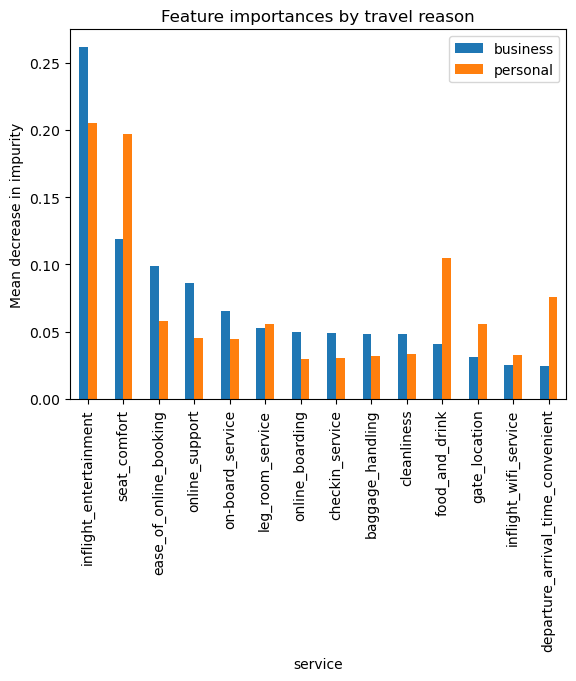

In [61]:
imp_travel_reasons.plot.bar(x='service')
plt.title("Feature importances by travel reason")
plt.ylabel("Mean decrease in impurity")
plt.legend(labels=['business','personal'])
plt.show()

There's some differences between the services that impact satisfaction for Business travelers vs Personal travelers.

For business, we see the ratings as:
1. inflight entertainment
2. seat comfort
3. ease of online booking
4. online support
5. on board service

While the top 5 for personal travelers are:
1. inflight entertainment
2. seat comfort
3. food and drink
4. convenient departure or arrival times
5. ease of online booking

The features where these two lists differ have fairly significant predictive differences. E.g., Food and Drink has an importance of 0.04 for business travelers, but 0.1 for personal travelers.

Recall we stated earlier in our study that we want to focus on bringing some of the disloyal business travelers into the loyalty scheme by improving their satisfaction, and looking at ways to improve the experience overall for personal travelers.

<b>This model suggests that the most resource-effienct way to do this would be by making improvements to some services of shared importance - inflight entertainment, seat comfort and the ease of online booking services.</b>

Distinguishing between personal vs business travelers during travel will be difficult, so improving the services both groups are said to value when it comes to predicting satisfaction could be of help.

### Other factors: class, distance

I wanted to use the same random forest model to look at the class of travel (we have economy, economy plus and business class on our airline). These may also have important relevance to our customer satisfaction.

#### Class
I'll look first at Class. We'll consider economy and economy plus customers together. We didn't examine class in detail above in our exploration, but it is an important factor when flying. Let's quickly look at the distribution of customers by class.

In [62]:
df.groupby('type_of_travel')['class'].value_counts()

type_of_travel   class   
Business travel  Business    59487
                 Eco         25304
                 Eco Plus     4902
Personal Travel  Eco         33005
                 Eco Plus     4509
                 Business     2673
Name: class, dtype: int64

In [63]:
fig = px.sunburst(df, path=['class','satisfaction'], title='Satisfaction by flight class',
                 color='satisfaction')

fig.update_traces(textinfo="label+percent parent")

fig.update_layout(
    autosize=False,
    height=500,
    width=500)

fig.show()

In [64]:
fig = px.sunburst(df, path=['class','type_of_travel'], title='Type of travel by flight class',
                 color='type_of_travel')

fig.update_traces(textinfo="label+percent parent")

fig.update_layout(
    autosize=False,
    height=500,
    width=500)

fig.show()

Our customers are fairly evenly spread between economy/economy plus and business class. However, business class customers are more likely to be satisfied, while economy and economy plus customers are on the whole more likely to be dissatisfied.

Our customers in business class are overwhelmingly more likely to be traveling for business, while economy customers are more often than than not leisure/personal travelers. We know that personal travelers are harder to please from our analysis earlier, so Class seems like a reasonable area to investigate further with our models.

In [65]:
#splitting datasets by customer class
df_business = df_processed[df_processed['Business'] == 1]
df_eco = df_processed[(df_processed['Eco'] == 1) | df_processed['Eco Plus'] == 1]

#drop unnecessary columns
df_business.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed','Business',
                              'Eco','Eco Plus'], inplace=True)

df_eco.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed','Business',
                              'Eco','Eco Plus'], inplace=True)

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2582409253.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2582409253.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
#setting up the Random Forest Model for Business class first
# Set up X and y variables
y, X = df_business['satisfaction'], df_business.drop(columns=['satisfaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_business.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train,y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.966


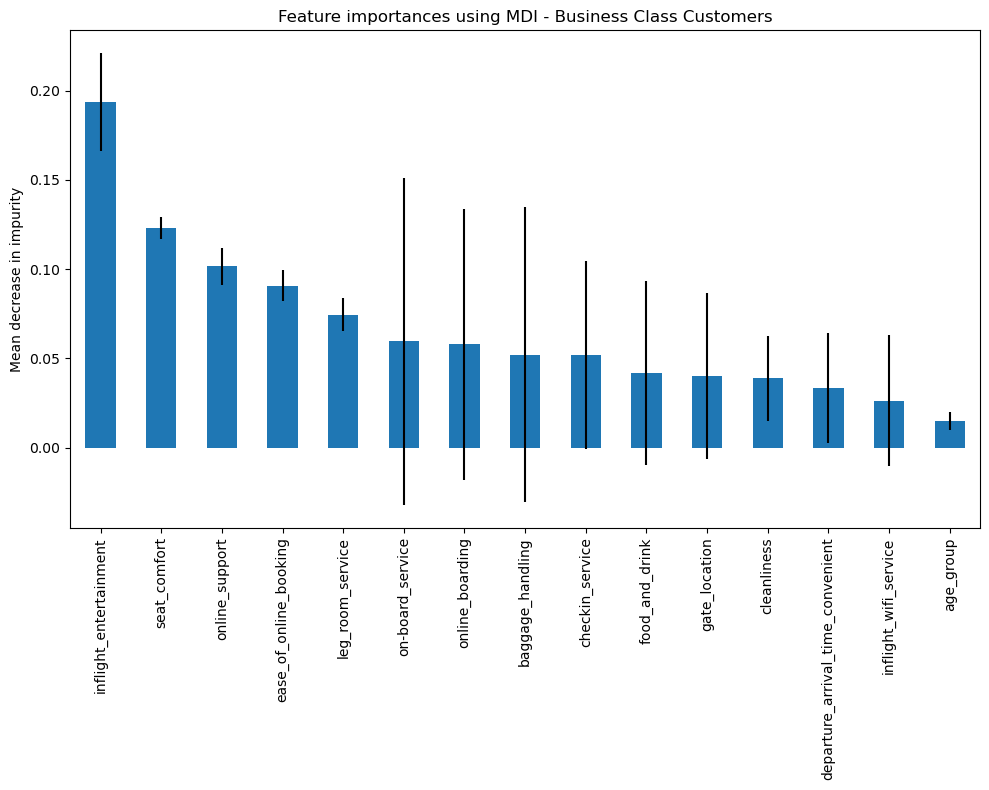

In [67]:
#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
rating_list_class = list(df_business.drop(columns=['satisfaction']).columns)
importances = forest.feature_importances_

forest_importances_biz = pd.Series(importances, index=rating_list_class).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances_biz.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI - Business Class Customers")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [68]:
#setting up the Random Forest Model for Economy Classes
# Set up X and y variables
y, X = df_eco['satisfaction'], df_eco.drop(columns=['satisfaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_eco.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train,y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

Accuracy on training set: 0.998
Accuracy on test set: 0.932


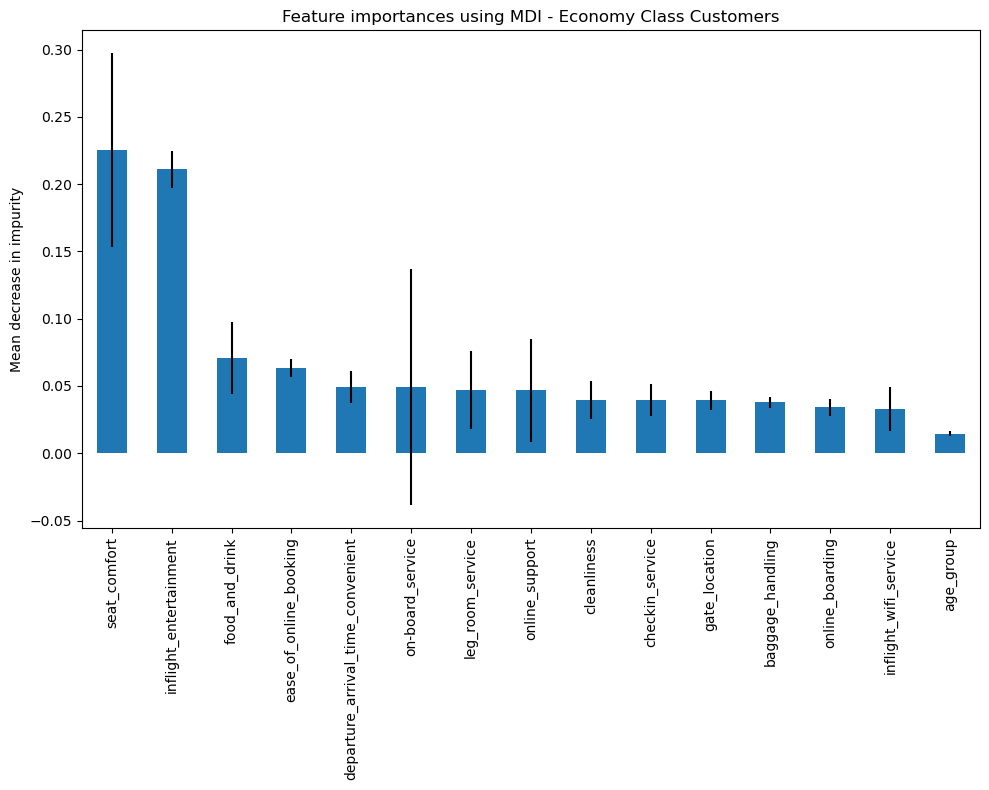

In [69]:
#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = forest.feature_importances_

forest_importances_eco = pd.Series(importances, index=rating_list_class).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances_eco.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI - Economy Class Customers")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

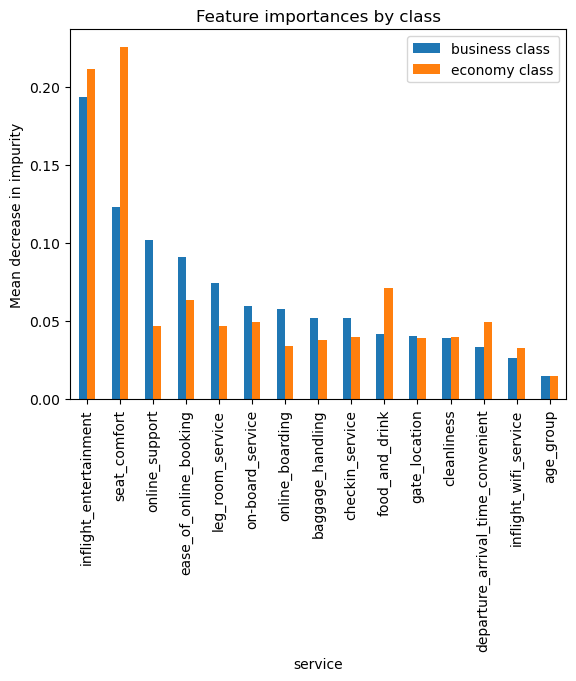

In [71]:
imp_biz = pd.DataFrame(forest_importances_biz).reset_index().rename(columns={'index':'service'
                                                                                       ,0:'importance'})
imp_eco = pd.DataFrame(forest_importances_eco).reset_index().rename(columns={'index':'service'
                                                                                       ,0:'importance'})
imp_class = imp_biz.merge(right=imp_eco, how='outer'
                                        , left_on='service'
                                        , right_on='service'
                                        , suffixes=('_biz','_eco'))


imp_class.plot.bar(x='service')
plt.title("Feature importances by class")
plt.ylabel("Mean decrease in impurity")
plt.legend(labels=['business class','economy class'])
plt.show()

I can see already a fairly good difference between the model's predicted feature importance for economy vs business class customers. 

The economy chart has two very important features - seat comfort and inflight entertainment - while most other features are of much less relevance.

Compare the business class chart, where we see that there is a wider range of importances across the features. Nevertheless, inflight entertainment and seat comfort are also the top two predictive features.

There is a similarity in the top 5 important features between our Business Class and our Business Travelers, and our Personal Travelers and Economy customers. E.g. both Personal and Economy traveler models have predicted that food and drink and departure/arrival time convenience rate in the top 5 for predicting satisfaction.

#### Flight Distance

I wonder as well whether flight distance has an impact on this. We can divide our flight distances into three, based on the histogram of flights vs satisfaction created much earlier in this project. We'll use those distances now.

Less than 1000 = short haul<br>
More than 1000 and less than 3000 = medium haul<br>
More than 3000 = long haul

These are aribtrary. Actually, the distances vs haul classification is quite subjective in reality, depending on the airlines usual destinations, the continent it operates from/in, and the type of aircraft in its fleet. These definitions will work for us today.

In [72]:
#splitting datasets by flight distance
short_haul = df[df['flight_distance'] < 1000]
mid_haul = df[(df['flight_distance'] > 1000) & (df['flight_distance'] < 3000 )]
long_haul = df[df['flight_distance'] > 3000]

In [74]:
#drop unnecessary columns
short_haul.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed', 'class'], inplace=True)

mid_haul.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed', 'class'], inplace=True)

long_haul.drop(columns=['gender', 'customer_type','age','type_of_travel','flight_distance',
                              'departure_delay_in_minutes','was_delayed', 'class'], inplace=True)

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2180948139.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2180948139.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2180948139.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
#Need to do the variable scaling again

for column in short_haul.columns:
    short_haul[column] = le.fit_transform(short_haul[column])
    mid_haul[column] = le.fit_transform(mid_haul[column])
    long_haul[column] = le.fit_transform(long_haul[column])

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2488120289.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2488120289.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jb/5csh6qnx4y7brg28_7d39qyw0000gq/T/ipykernel_81971/2488120289.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [77]:
long_haul.head(3)

satisfaction  seat_comfort  departure_arrival_time_convenient  \
11             1             0                                  0   
16             1             0                                  1   
19             1             0                                  1   

    food_and_drink  gate_location  inflight_wifi_service  \
11               0              3                      2   
16               0              1                      4   
19               0              1                      3   

    inflight_entertainment  online_support  ease_of_online_booking  \
11                       0               1                       2   
16                       0               3                       4   
19                       0               2                       3   

    on-board_service  leg_room_service  baggage_handling  checkin_service  \
11                 3                 2                 4                1   
16                 4                 4                 0                2   
19                 2                 5                 1                2   

    cleanliness  online_boarding  age_group  
11            5                2          1  
16            1                4          1  
19            2                3          1

Accuracy on training set: 0.998
Accuracy on test set: 0.950


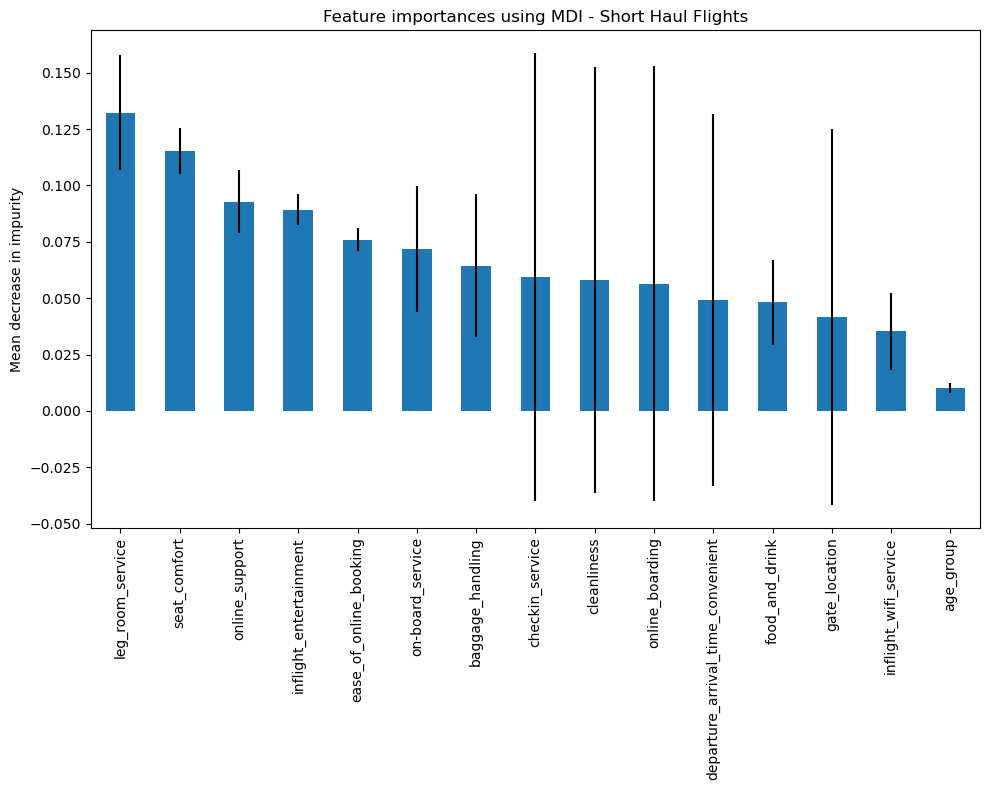

In [78]:
#setting up the Random Forest Model for short haul
# Set up X and y variables
y, X = short_haul['satisfaction'], short_haul.drop(columns=['satisfaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=short_haul.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train,y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = forest.feature_importances_

forest_importances_sh = pd.Series(importances, index=rating_list_class).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances_sh.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI - Short Haul Flights")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Accuracy on training set: 0.997
Accuracy on test set: 0.936


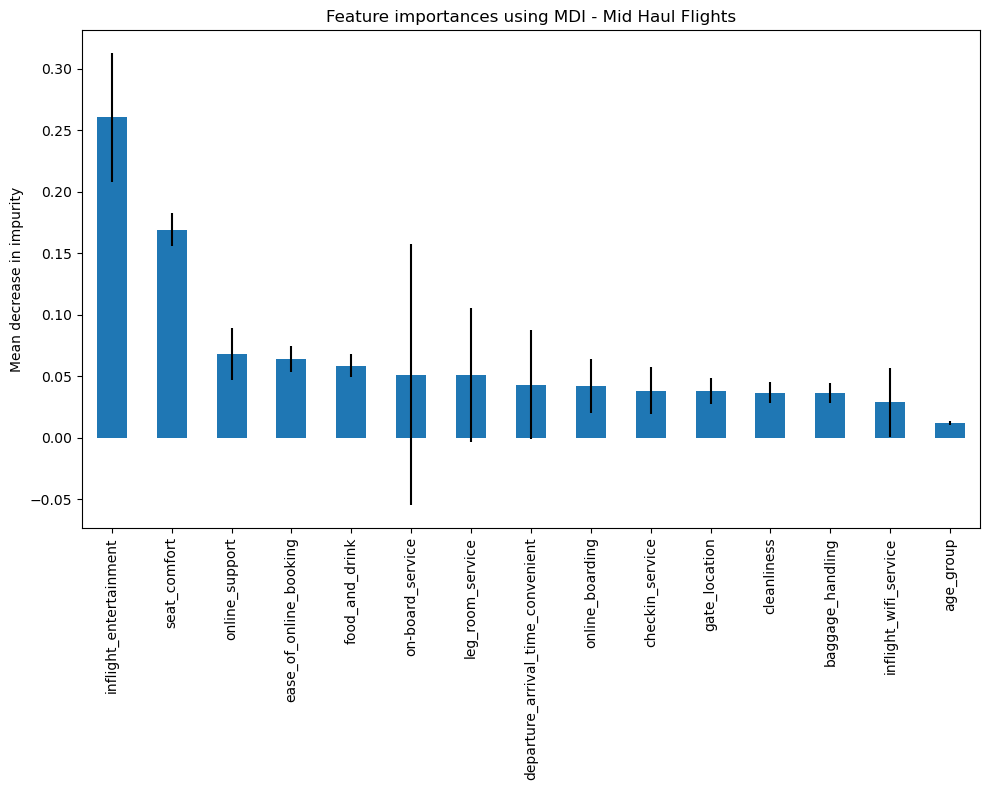

In [79]:
#setting up the Random Forest Model for mid_haul
# Set up X and y variables
y, X = mid_haul['satisfaction'], mid_haul.drop(columns=['satisfaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=mid_haul.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=300, random_state=1)
forest.fit(X_train,y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = forest.feature_importances_

forest_importances_mh = pd.Series(importances, index=rating_list_class).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances_mh.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI - Mid Haul Flights")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Accuracy on training set: 1.000
Accuracy on test set: 0.953


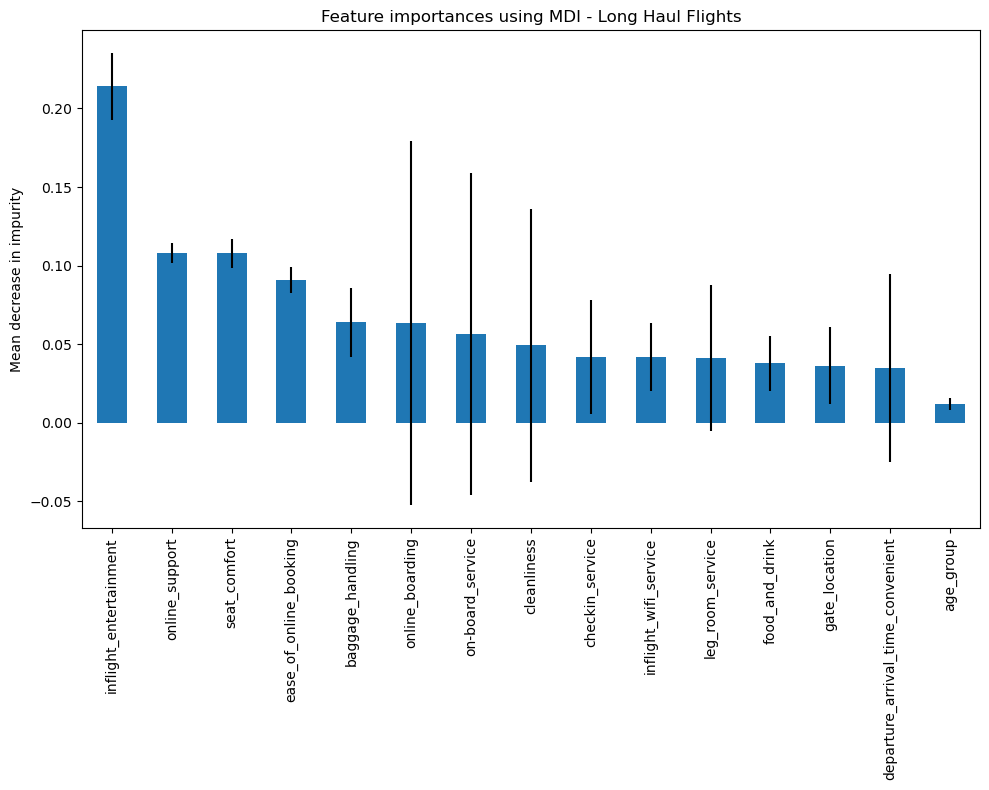

In [80]:
#setting up the Random Forest Model for long_haul
# Set up X and y variables
y, X = long_haul['satisfaction'], long_haul.drop(columns=['satisfaction'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=long_haul.satisfaction, random_state=1)

forest = RandomForestClassifier(n_estimators=300, random_state=1)
forest.fit(X_train,y_train)

print('Accuracy on training set: {:.3f}'.format(forest.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test,y_test)))

#code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = forest.feature_importances_

forest_importances_lh = pd.Series(importances, index=rating_list_class).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,8))
forest_importances_lh.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI - Long Haul Flights")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We're seeing some interesting differences between the groups here.

In [83]:
imp_sh = pd.DataFrame(forest_importances_sh).reset_index().rename(columns={'index':'service'
                                                                                       ,0:'importance'})
imp_mh = pd.DataFrame(forest_importances_mh).reset_index().rename(columns={'index':'service'
                                                                                       ,0:'importance'})
imp_lh = pd.DataFrame(forest_importances_lh).reset_index().rename(columns={'index':'service'
                                                                                       ,0:'importance'})
imp_distance = imp_sh.merge(right=imp_mh, how='outer'
                                        , left_on='service'
                                        , right_on='service'
                                        , suffixes=('_sh','_mh'))

imp_distance = imp_distance.merge(right=imp_lh, left_on='service', right_on='service')
imp_distance.rename(columns={'importance':'importance_lh'}, inplace=True)

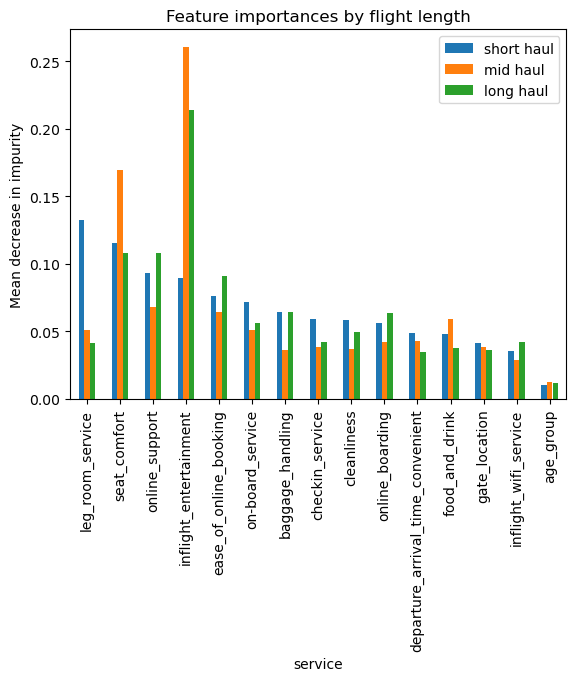

In [84]:
imp_distance.plot.bar(x='service')
plt.title("Feature importances by flight length")
plt.ylabel("Mean decrease in impurity")
plt.legend(labels=['short haul','mid haul','long haul'])
plt.show()

This is a particularly revealing insight. For short haul flights, the two most important services for predicting satisfaction are leg room and seat comfort. For mid and long haul flights is inflight entertainment and seat comfort (although to differeing degrees). 


## Conclusions

We've divided our customer survey in a number of ways and found satisfaction differences between groups. The reason for travel can have a big impact on satisfaction and customer loyalty, and to a lesser extent age.

Nevertheless, we have found through machine learning/predictive modelling that there are some flight services in common across groups (class, flight distance and travel reasons) which have a strong ability to predict whether a customer will be satisfied.

Improvements to these shared services could bring much more satisfaction to our customers, improving customer loyalty and retention.

These services are:

1. Inflight entertainment
2. Seat comfort
3. Online support and the ease of booking online

These appear to be the areas where we will see the most satisfaction improvement across the widest range of customers. They are therefore the most resource efficient areas to improve.

A longer list would also include:
- Improved food and drink for economy customers, where our Personal/Leisure travels are often seated. Personal travelers are more mixed in their satisfaction than customers traveling for business, so appealing to these users could improve satisfaction levels overall to a good degree.
- Improved legroom on our short-haul services (e.g., are our short-haul services using a particular fleet of aircraft that could be upgraded in time?)
- Consider adjustments to our departure or arrival times to improve customer convenience.